# [1]. Reading Data

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os

In [137]:
con = sqlite3.connect('database.sqlite') 
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [138]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [139]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [140]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [143]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [144]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [145]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [146]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [147]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

#  Preprocessing

In [152]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"haven't", "will not", phrase)
    phrase = re.sub(r"wasn\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [156]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [157]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 46071/46071 [00:13<00:00, 3331.56it/s]


In [117]:
preprocessed_reviews[1500]

'chips truly amazing light crisp great tasting nice texture natural low fat sodium need say recently bought bag regular grocery store could not belive taste buds excited saw amazon decided buy case'

# Creating the vocabolary:

In [158]:
words = []
for k in preprocessed_reviews:
    for word in k.split(' '):
        if word not in words:
            words.append(word) 

In [159]:
all_reviews = []
for k in preprocessed_reviews:
    for word in k.split(' '):
        all_reviews.append(word)

In [160]:
print("Total number of unique words in thhe dataset: ",len(words))
print("Total words in the dataset: ",len(all_reviews))

Total number of unique words in thhe dataset:  39383
Total words in the dataset:  1797914


In [161]:
# initializing the dictionary with all unique values
dictionary = {}
for k in all_reviews:
        dictionary[k] = 0 

In [162]:
for k in all_reviews:
    dictionary[k] = dictionary[k]+1   # creating the dictionary from the given reviews

In [163]:
import operator
sorted_dict = sorted(dictionary.items(), key=operator.itemgetter(1))  # sorting the dictionary

In [164]:
sd = sorted_dict[::-1]   # containing all the words count in dec order
sd[:10]

[('not', 47477),
 ('like', 19883),
 ('good', 15918),
 ('great', 13790),
 ('one', 13705),
 ('taste', 13299),
 ('would', 12428),
 ('product', 11816),
 ('coffee', 11104),
 ('flavor', 10982)]

In [165]:
#sd = sorted_dict[: :-1]
print("TOP WORDS\t\t\t"+"FREQUENCY")
count = 0
for d in sd:
    if count ==10:
        break
    print(d[0],"\t\t\t\t",d[1])
    count = count+1  

TOP WORDS			FREQUENCY
not 				 47477
like 				 19883
good 				 15918
great 				 13790
one 				 13705
taste 				 13299
would 				 12428
product 				 11816
coffee 				 11104
flavor 				 10982


In [166]:
len(sd)

39383

In [167]:
final_words = []
for word in sd:
    final_words.append(word[0])

In [168]:
new_reviews = []   # it will contain the numerical representation of the reviews
for f in preprocessed_reviews:
    l = []
    for k in f.split(' '):
        if k in final_words:
            ind = final_words.index(k)
            l.append(ind+1)
    new_reviews.append(l)

In [169]:
# deviding the data into train and test
y = final['Score'].values
y_train=y[0:40000]
x_train=new_reviews[0:40000]
y_test=y[40000:]
x_test=new_reviews[40000:]

In [170]:
# padding the dataset
from tensorflow.keras.preprocessing import sequence
max_review_length = 600
x_train=sequence.pad_sequences(x_train,maxlen=max_review_length)
x_test=sequence.pad_sequences(x_test,maxlen=max_review_length)
print("Training data Shape",x_train.shape)

Training data Shape (40000, 600)


In [212]:
y_train = np.array(y_train)
y_test = np.array(y_test)

### BiLSTM model

In [188]:
batch_size = 32
model = Sequential()
model.add(Embedding(40000, 128, input_length=600))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 600, 128)          5120000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total params: 5,218,945
Trainable params: 5,218,945
Non-trainable params: 0
_________________________________________________________________


In [189]:
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,batch_size=batch_size,epochs=4,validation_data=[x_test, y_test])

Train on 40000 samples, validate on 6071 samples
Epoch 1/4


 5632/40000 [===>..........................] - ETA: 49:34 - loss: 0.6843 - accuracy: 0.687 - ETA: 33:42 - loss: 0.6762 - accuracy: 0.734 - ETA: 28:09 - loss: 0.6668 - accuracy: 0.760 - ETA: 25:17 - loss: 0.6594 - accuracy: 0.773 - ETA: 23:30 - loss: 0.6482 - accuracy: 0.787 - ETA: 22:23 - loss: 0.6328 - accuracy: 0.807 - ETA: 21:23 - loss: 0.6203 - accuracy: 0.817 - ETA: 20:36 - loss: 0.6098 - accuracy: 0.820 - ETA: 20:14 - loss: 0.5977 - accuracy: 0.822 - ETA: 19:53 - loss: 0.5961 - accuracy: 0.815 - ETA: 19:43 - loss: 0.5874 - accuracy: 0.815 - ETA: 19:33 - loss: 0.5827 - accuracy: 0.812 - ETA: 19:22 - loss: 0.5580 - accuracy: 0.822 - ETA: 19:15 - loss: 0.5520 - accuracy: 0.823 - ETA: 18:59 - loss: 0.5497 - accuracy: 0.822 - ETA: 18:52 - loss: 0.5419 - accuracy: 0.824 - ETA: 18:45 - loss: 0.5209 - accuracy: 0.832 - ETA: 18:35 - loss: 0.5256 - accuracy: 0.829 - ETA: 18:28 - loss: 0.5240 - accuracy: 0.828 - ETA: 18:21 - loss: 0.5244 - accuracy: 0.826 - ETA: 18:18 - loss: 0.5178 - accur

11328/40000 [=======>......................] - ETA: 15:05 - loss: 0.3646 - accuracy: 0.857 - ETA: 15:04 - loss: 0.3639 - accuracy: 0.857 - ETA: 15:03 - loss: 0.3645 - accuracy: 0.856 - ETA: 15:02 - loss: 0.3671 - accuracy: 0.854 - ETA: 15:01 - loss: 0.3690 - accuracy: 0.852 - ETA: 15:00 - loss: 0.3690 - accuracy: 0.852 - ETA: 15:00 - loss: 0.3691 - accuracy: 0.852 - ETA: 14:59 - loss: 0.3690 - accuracy: 0.852 - ETA: 14:57 - loss: 0.3685 - accuracy: 0.852 - ETA: 14:56 - loss: 0.3685 - accuracy: 0.853 - ETA: 14:55 - loss: 0.3678 - accuracy: 0.853 - ETA: 14:54 - loss: 0.3678 - accuracy: 0.853 - ETA: 14:53 - loss: 0.3679 - accuracy: 0.853 - ETA: 14:52 - loss: 0.3669 - accuracy: 0.854 - ETA: 14:51 - loss: 0.3661 - accuracy: 0.854 - ETA: 14:50 - loss: 0.3667 - accuracy: 0.854 - ETA: 14:50 - loss: 0.3667 - accuracy: 0.854 - ETA: 14:49 - loss: 0.3666 - accuracy: 0.853 - ETA: 14:47 - loss: 0.3663 - accuracy: 0.853 - ETA: 14:46 - loss: 0.3658 - accuracy: 0.854 - ETA: 14:46 - loss: 0.3654 - accur

17024/40000 [===========>..................] - ETA: 12:40 - loss: 0.3236 - accuracy: 0.871 - ETA: 12:39 - loss: 0.3229 - accuracy: 0.871 - ETA: 12:39 - loss: 0.3231 - accuracy: 0.871 - ETA: 12:38 - loss: 0.3236 - accuracy: 0.871 - ETA: 12:37 - loss: 0.3236 - accuracy: 0.871 - ETA: 12:36 - loss: 0.3233 - accuracy: 0.871 - ETA: 12:36 - loss: 0.3228 - accuracy: 0.871 - ETA: 12:35 - loss: 0.3225 - accuracy: 0.872 - ETA: 12:35 - loss: 0.3222 - accuracy: 0.872 - ETA: 12:34 - loss: 0.3220 - accuracy: 0.872 - ETA: 12:34 - loss: 0.3216 - accuracy: 0.872 - ETA: 12:33 - loss: 0.3218 - accuracy: 0.872 - ETA: 12:33 - loss: 0.3213 - accuracy: 0.872 - ETA: 12:32 - loss: 0.3212 - accuracy: 0.873 - ETA: 12:31 - loss: 0.3211 - accuracy: 0.872 - ETA: 12:30 - loss: 0.3209 - accuracy: 0.873 - ETA: 12:30 - loss: 0.3207 - accuracy: 0.873 - ETA: 12:29 - loss: 0.3203 - accuracy: 0.873 - ETA: 12:29 - loss: 0.3202 - accuracy: 0.873 - ETA: 12:28 - loss: 0.3198 - accuracy: 0.873 - ETA: 12:27 - loss: 0.3193 - accur

22912/40000 [================>.............] - ETA: 10:27 - loss: 0.2944 - accuracy: 0.885 - ETA: 10:26 - loss: 0.2948 - accuracy: 0.884 - ETA: 10:26 - loss: 0.2952 - accuracy: 0.884 - ETA: 10:25 - loss: 0.2950 - accuracy: 0.884 - ETA: 10:24 - loss: 0.2947 - accuracy: 0.885 - ETA: 10:23 - loss: 0.2944 - accuracy: 0.885 - ETA: 10:22 - loss: 0.2944 - accuracy: 0.885 - ETA: 10:21 - loss: 0.2945 - accuracy: 0.885 - ETA: 10:21 - loss: 0.2943 - accuracy: 0.885 - ETA: 10:20 - loss: 0.2940 - accuracy: 0.885 - ETA: 10:19 - loss: 0.2940 - accuracy: 0.885 - ETA: 10:18 - loss: 0.2943 - accuracy: 0.885 - ETA: 10:17 - loss: 0.2939 - accuracy: 0.885 - ETA: 10:17 - loss: 0.2937 - accuracy: 0.885 - ETA: 10:16 - loss: 0.2935 - accuracy: 0.885 - ETA: 10:15 - loss: 0.2933 - accuracy: 0.885 - ETA: 10:14 - loss: 0.2930 - accuracy: 0.885 - ETA: 10:13 - loss: 0.2927 - accuracy: 0.885 - ETA: 10:12 - loss: 0.2925 - accuracy: 0.885 - ETA: 10:12 - loss: 0.2927 - accuracy: 0.885 - ETA: 10:11 - loss: 0.2929 - accur

28864/40000 [====================>.........] - ETA: 7:55 - loss: 0.2784 - accuracy: 0.89 - ETA: 7:54 - loss: 0.2785 - accuracy: 0.89 - ETA: 7:53 - loss: 0.2784 - accuracy: 0.89 - ETA: 7:53 - loss: 0.2783 - accuracy: 0.89 - ETA: 7:52 - loss: 0.2780 - accuracy: 0.89 - ETA: 7:51 - loss: 0.2780 - accuracy: 0.89 - ETA: 7:50 - loss: 0.2779 - accuracy: 0.89 - ETA: 7:50 - loss: 0.2778 - accuracy: 0.89 - ETA: 7:49 - loss: 0.2776 - accuracy: 0.89 - ETA: 7:48 - loss: 0.2774 - accuracy: 0.89 - ETA: 7:47 - loss: 0.2774 - accuracy: 0.89 - ETA: 7:46 - loss: 0.2774 - accuracy: 0.89 - ETA: 7:45 - loss: 0.2773 - accuracy: 0.89 - ETA: 7:45 - loss: 0.2772 - accuracy: 0.89 - ETA: 7:44 - loss: 0.2772 - accuracy: 0.89 - ETA: 7:43 - loss: 0.2770 - accuracy: 0.89 - ETA: 7:42 - loss: 0.2772 - accuracy: 0.89 - ETA: 7:41 - loss: 0.2772 - accuracy: 0.89 - ETA: 7:40 - loss: 0.2769 - accuracy: 0.89 - ETA: 7:39 - loss: 0.2767 - accuracy: 0.89 - ETA: 7:39 - loss: 0.2766 - accuracy: 0.89 - ETA: 7:38 - loss: 0.2764 - ac

34816/40000 [=========================>....] - ETA: 5:12 - loss: 0.2685 - accuracy: 0.89 - ETA: 5:11 - loss: 0.2683 - accuracy: 0.89 - ETA: 5:10 - loss: 0.2682 - accuracy: 0.89 - ETA: 5:09 - loss: 0.2680 - accuracy: 0.89 - ETA: 5:09 - loss: 0.2681 - accuracy: 0.89 - ETA: 5:08 - loss: 0.2680 - accuracy: 0.89 - ETA: 5:07 - loss: 0.2684 - accuracy: 0.89 - ETA: 5:06 - loss: 0.2685 - accuracy: 0.89 - ETA: 5:05 - loss: 0.2683 - accuracy: 0.89 - ETA: 5:04 - loss: 0.2683 - accuracy: 0.89 - ETA: 5:03 - loss: 0.2683 - accuracy: 0.89 - ETA: 5:02 - loss: 0.2681 - accuracy: 0.89 - ETA: 5:01 - loss: 0.2682 - accuracy: 0.89 - ETA: 5:01 - loss: 0.2681 - accuracy: 0.89 - ETA: 5:00 - loss: 0.2680 - accuracy: 0.89 - ETA: 4:59 - loss: 0.2681 - accuracy: 0.89 - ETA: 4:58 - loss: 0.2681 - accuracy: 0.89 - ETA: 4:57 - loss: 0.2680 - accuracy: 0.89 - ETA: 4:56 - loss: 0.2680 - accuracy: 0.89 - ETA: 4:55 - loss: 0.2678 - accuracy: 0.89 - ETA: 4:54 - loss: 0.2679 - accuracy: 0.89 - ETA: 4:54 - loss: 0.2680 - ac

40000/40000 [==============================] - ETA: 2:25 - loss: 0.2615 - accuracy: 0.89 - ETA: 2:25 - loss: 0.2616 - accuracy: 0.89 - ETA: 2:24 - loss: 0.2614 - accuracy: 0.89 - ETA: 2:23 - loss: 0.2615 - accuracy: 0.89 - ETA: 2:22 - loss: 0.2613 - accuracy: 0.89 - ETA: 2:21 - loss: 0.2613 - accuracy: 0.89 - ETA: 2:20 - loss: 0.2612 - accuracy: 0.89 - ETA: 2:19 - loss: 0.2610 - accuracy: 0.89 - ETA: 2:18 - loss: 0.2609 - accuracy: 0.89 - ETA: 2:17 - loss: 0.2609 - accuracy: 0.89 - ETA: 2:16 - loss: 0.2609 - accuracy: 0.89 - ETA: 2:16 - loss: 0.2609 - accuracy: 0.89 - ETA: 2:15 - loss: 0.2610 - accuracy: 0.89 - ETA: 2:14 - loss: 0.2609 - accuracy: 0.89 - ETA: 2:13 - loss: 0.2610 - accuracy: 0.89 - ETA: 2:12 - loss: 0.2609 - accuracy: 0.89 - ETA: 2:11 - loss: 0.2610 - accuracy: 0.89 - ETA: 2:10 - loss: 0.2609 - accuracy: 0.89 - ETA: 2:09 - loss: 0.2609 - accuracy: 0.89 - ETA: 2:08 - loss: 0.2610 - accuracy: 0.89 - ETA: 2:07 - loss: 0.2609 - accuracy: 0.89 - ETA: 2:07 - loss: 0.2608 - ac

 5696/40000 [===>..........................] - ETA: 17:51 - loss: 0.1819 - accuracy: 0.906 - ETA: 17:32 - loss: 0.2621 - accuracy: 0.906 - ETA: 17:49 - loss: 0.2199 - accuracy: 0.916 - ETA: 18:01 - loss: 0.2157 - accuracy: 0.914 - ETA: 18:14 - loss: 0.1989 - accuracy: 0.925 - ETA: 18:33 - loss: 0.1922 - accuracy: 0.932 - ETA: 18:29 - loss: 0.1796 - accuracy: 0.937 - ETA: 18:21 - loss: 0.1749 - accuracy: 0.941 - ETA: 18:15 - loss: 0.1740 - accuracy: 0.941 - ETA: 18:12 - loss: 0.1654 - accuracy: 0.943 - ETA: 18:06 - loss: 0.1606 - accuracy: 0.946 - ETA: 18:00 - loss: 0.1612 - accuracy: 0.945 - ETA: 17:57 - loss: 0.1525 - accuracy: 0.949 - ETA: 17:56 - loss: 0.1499 - accuracy: 0.950 - ETA: 17:56 - loss: 0.1527 - accuracy: 0.947 - ETA: 17:54 - loss: 0.1496 - accuracy: 0.949 - ETA: 17:57 - loss: 0.1568 - accuracy: 0.946 - ETA: 18:00 - loss: 0.1591 - accuracy: 0.944 - ETA: 18:02 - loss: 0.1566 - accuracy: 0.947 - ETA: 18:01 - loss: 0.1517 - accuracy: 0.948 - ETA: 18:01 - loss: 0.1504 - accur

11392/40000 [=======>......................] - ETA: 15:40 - loss: 0.1340 - accuracy: 0.951 - ETA: 15:39 - loss: 0.1351 - accuracy: 0.951 - ETA: 15:38 - loss: 0.1352 - accuracy: 0.951 - ETA: 15:37 - loss: 0.1359 - accuracy: 0.951 - ETA: 15:36 - loss: 0.1357 - accuracy: 0.951 - ETA: 15:35 - loss: 0.1351 - accuracy: 0.951 - ETA: 15:34 - loss: 0.1356 - accuracy: 0.951 - ETA: 15:33 - loss: 0.1362 - accuracy: 0.951 - ETA: 15:32 - loss: 0.1361 - accuracy: 0.951 - ETA: 15:31 - loss: 0.1357 - accuracy: 0.951 - ETA: 15:30 - loss: 0.1361 - accuracy: 0.951 - ETA: 15:30 - loss: 0.1362 - accuracy: 0.951 - ETA: 15:29 - loss: 0.1367 - accuracy: 0.950 - ETA: 15:28 - loss: 0.1364 - accuracy: 0.951 - ETA: 15:27 - loss: 0.1361 - accuracy: 0.951 - ETA: 15:26 - loss: 0.1367 - accuracy: 0.951 - ETA: 15:25 - loss: 0.1363 - accuracy: 0.951 - ETA: 15:24 - loss: 0.1364 - accuracy: 0.951 - ETA: 15:23 - loss: 0.1362 - accuracy: 0.951 - ETA: 15:22 - loss: 0.1362 - accuracy: 0.951 - ETA: 15:21 - loss: 0.1360 - accur

17088/40000 [===========>..................] - ETA: 13:59 - loss: 0.1345 - accuracy: 0.951 - ETA: 13:58 - loss: 0.1345 - accuracy: 0.951 - ETA: 13:58 - loss: 0.1344 - accuracy: 0.951 - ETA: 13:57 - loss: 0.1346 - accuracy: 0.951 - ETA: 13:57 - loss: 0.1344 - accuracy: 0.951 - ETA: 13:56 - loss: 0.1342 - accuracy: 0.951 - ETA: 13:55 - loss: 0.1339 - accuracy: 0.951 - ETA: 13:54 - loss: 0.1342 - accuracy: 0.951 - ETA: 13:53 - loss: 0.1343 - accuracy: 0.951 - ETA: 13:53 - loss: 0.1341 - accuracy: 0.951 - ETA: 13:52 - loss: 0.1338 - accuracy: 0.952 - ETA: 13:51 - loss: 0.1339 - accuracy: 0.951 - ETA: 13:51 - loss: 0.1339 - accuracy: 0.952 - ETA: 13:50 - loss: 0.1340 - accuracy: 0.951 - ETA: 13:49 - loss: 0.1341 - accuracy: 0.951 - ETA: 13:49 - loss: 0.1344 - accuracy: 0.951 - ETA: 13:48 - loss: 0.1343 - accuracy: 0.951 - ETA: 13:47 - loss: 0.1350 - accuracy: 0.951 - ETA: 13:47 - loss: 0.1348 - accuracy: 0.951 - ETA: 13:46 - loss: 0.1348 - accuracy: 0.951 - ETA: 13:45 - loss: 0.1346 - accur

22880/40000 [================>.............] - ETA: 11:38 - loss: 0.1374 - accuracy: 0.951 - ETA: 11:37 - loss: 0.1374 - accuracy: 0.951 - ETA: 11:36 - loss: 0.1375 - accuracy: 0.950 - ETA: 11:35 - loss: 0.1376 - accuracy: 0.950 - ETA: 11:35 - loss: 0.1378 - accuracy: 0.950 - ETA: 11:34 - loss: 0.1377 - accuracy: 0.950 - ETA: 11:33 - loss: 0.1378 - accuracy: 0.950 - ETA: 11:32 - loss: 0.1377 - accuracy: 0.950 - ETA: 11:31 - loss: 0.1377 - accuracy: 0.950 - ETA: 11:31 - loss: 0.1375 - accuracy: 0.950 - ETA: 11:30 - loss: 0.1374 - accuracy: 0.950 - ETA: 11:29 - loss: 0.1378 - accuracy: 0.950 - ETA: 11:28 - loss: 0.1377 - accuracy: 0.950 - ETA: 11:27 - loss: 0.1376 - accuracy: 0.950 - ETA: 11:26 - loss: 0.1377 - accuracy: 0.950 - ETA: 11:25 - loss: 0.1381 - accuracy: 0.950 - ETA: 11:25 - loss: 0.1382 - accuracy: 0.950 - ETA: 11:24 - loss: 0.1381 - accuracy: 0.950 - ETA: 11:23 - loss: 0.1380 - accuracy: 0.950 - ETA: 11:22 - loss: 0.1379 - accuracy: 0.950 - ETA: 11:21 - loss: 0.1383 - accur

28832/40000 [====================>.........] - ETA: 8:54 - loss: 0.1405 - accuracy: 0.94 - ETA: 8:54 - loss: 0.1406 - accuracy: 0.94 - ETA: 8:53 - loss: 0.1407 - accuracy: 0.94 - ETA: 8:52 - loss: 0.1406 - accuracy: 0.94 - ETA: 8:51 - loss: 0.1405 - accuracy: 0.94 - ETA: 8:50 - loss: 0.1404 - accuracy: 0.94 - ETA: 8:49 - loss: 0.1403 - accuracy: 0.94 - ETA: 8:48 - loss: 0.1404 - accuracy: 0.94 - ETA: 8:47 - loss: 0.1405 - accuracy: 0.94 - ETA: 8:46 - loss: 0.1404 - accuracy: 0.94 - ETA: 8:45 - loss: 0.1404 - accuracy: 0.94 - ETA: 8:44 - loss: 0.1406 - accuracy: 0.94 - ETA: 8:43 - loss: 0.1405 - accuracy: 0.94 - ETA: 8:42 - loss: 0.1407 - accuracy: 0.94 - ETA: 8:41 - loss: 0.1405 - accuracy: 0.94 - ETA: 8:40 - loss: 0.1405 - accuracy: 0.94 - ETA: 8:39 - loss: 0.1405 - accuracy: 0.94 - ETA: 8:38 - loss: 0.1404 - accuracy: 0.94 - ETA: 8:37 - loss: 0.1404 - accuracy: 0.94 - ETA: 8:36 - loss: 0.1407 - accuracy: 0.94 - ETA: 8:35 - loss: 0.1409 - accuracy: 0.94 - ETA: 8:35 - loss: 0.1410 - ac

34784/40000 [=========================>....] - ETA: 5:53 - loss: 0.1445 - accuracy: 0.94 - ETA: 5:52 - loss: 0.1446 - accuracy: 0.94 - ETA: 5:51 - loss: 0.1446 - accuracy: 0.94 - ETA: 5:50 - loss: 0.1446 - accuracy: 0.94 - ETA: 5:49 - loss: 0.1447 - accuracy: 0.94 - ETA: 5:48 - loss: 0.1446 - accuracy: 0.94 - ETA: 5:47 - loss: 0.1448 - accuracy: 0.94 - ETA: 5:46 - loss: 0.1447 - accuracy: 0.94 - ETA: 5:45 - loss: 0.1446 - accuracy: 0.94 - ETA: 5:44 - loss: 0.1446 - accuracy: 0.94 - ETA: 5:43 - loss: 0.1447 - accuracy: 0.94 - ETA: 5:42 - loss: 0.1448 - accuracy: 0.94 - ETA: 5:41 - loss: 0.1447 - accuracy: 0.94 - ETA: 5:40 - loss: 0.1446 - accuracy: 0.94 - ETA: 5:39 - loss: 0.1446 - accuracy: 0.94 - ETA: 5:38 - loss: 0.1445 - accuracy: 0.94 - ETA: 5:37 - loss: 0.1445 - accuracy: 0.94 - ETA: 5:36 - loss: 0.1445 - accuracy: 0.94 - ETA: 5:35 - loss: 0.1444 - accuracy: 0.94 - ETA: 5:34 - loss: 0.1443 - accuracy: 0.94 - ETA: 5:33 - loss: 0.1443 - accuracy: 0.94 - ETA: 5:32 - loss: 0.1443 - ac

40000/40000 [==============================] - ETA: 2:46 - loss: 0.1467 - accuracy: 0.94 - ETA: 2:45 - loss: 0.1467 - accuracy: 0.94 - ETA: 2:44 - loss: 0.1467 - accuracy: 0.94 - ETA: 2:43 - loss: 0.1466 - accuracy: 0.94 - ETA: 2:42 - loss: 0.1467 - accuracy: 0.94 - ETA: 2:41 - loss: 0.1467 - accuracy: 0.94 - ETA: 2:40 - loss: 0.1466 - accuracy: 0.94 - ETA: 2:39 - loss: 0.1467 - accuracy: 0.94 - ETA: 2:38 - loss: 0.1468 - accuracy: 0.94 - ETA: 2:37 - loss: 0.1467 - accuracy: 0.94 - ETA: 2:36 - loss: 0.1466 - accuracy: 0.94 - ETA: 2:35 - loss: 0.1467 - accuracy: 0.94 - ETA: 2:34 - loss: 0.1467 - accuracy: 0.94 - ETA: 2:33 - loss: 0.1466 - accuracy: 0.94 - ETA: 2:32 - loss: 0.1466 - accuracy: 0.94 - ETA: 2:31 - loss: 0.1465 - accuracy: 0.94 - ETA: 2:30 - loss: 0.1466 - accuracy: 0.94 - ETA: 2:29 - loss: 0.1466 - accuracy: 0.94 - ETA: 2:28 - loss: 0.1467 - accuracy: 0.94 - ETA: 2:27 - loss: 0.1466 - accuracy: 0.94 - ETA: 2:26 - loss: 0.1466 - accuracy: 0.94 - ETA: 2:25 - loss: 0.1467 - ac

 5696/40000 [===>..........................] - ETA: 22:14 - loss: 0.0462 - accuracy: 1.000 - ETA: 21:18 - loss: 0.0785 - accuracy: 0.984 - ETA: 21:28 - loss: 0.0792 - accuracy: 0.979 - ETA: 21:46 - loss: 0.0726 - accuracy: 0.984 - ETA: 21:46 - loss: 0.0642 - accuracy: 0.987 - ETA: 21:46 - loss: 0.0595 - accuracy: 0.989 - ETA: 21:55 - loss: 0.0645 - accuracy: 0.986 - ETA: 22:00 - loss: 0.0593 - accuracy: 0.988 - ETA: 21:55 - loss: 0.0576 - accuracy: 0.986 - ETA: 21:50 - loss: 0.0638 - accuracy: 0.981 - ETA: 22:01 - loss: 0.0637 - accuracy: 0.980 - ETA: 22:03 - loss: 0.0592 - accuracy: 0.981 - ETA: 22:04 - loss: 0.0563 - accuracy: 0.983 - ETA: 22:03 - loss: 0.0573 - accuracy: 0.979 - ETA: 22:02 - loss: 0.0586 - accuracy: 0.979 - ETA: 22:05 - loss: 0.0584 - accuracy: 0.980 - ETA: 22:06 - loss: 0.0590 - accuracy: 0.979 - ETA: 22:03 - loss: 0.0578 - accuracy: 0.979 - ETA: 21:59 - loss: 0.0632 - accuracy: 0.975 - ETA: 22:00 - loss: 0.0665 - accuracy: 0.975 - ETA: 21:59 - loss: 0.0731 - accur

11392/40000 [=======>......................] - ETA: 20:29 - loss: 0.0785 - accuracy: 0.973 - ETA: 20:28 - loss: 0.0786 - accuracy: 0.973 - ETA: 20:26 - loss: 0.0784 - accuracy: 0.973 - ETA: 20:25 - loss: 0.0788 - accuracy: 0.973 - ETA: 20:24 - loss: 0.0791 - accuracy: 0.973 - ETA: 20:23 - loss: 0.0789 - accuracy: 0.973 - ETA: 20:21 - loss: 0.0793 - accuracy: 0.973 - ETA: 20:20 - loss: 0.0802 - accuracy: 0.973 - ETA: 20:18 - loss: 0.0806 - accuracy: 0.972 - ETA: 20:17 - loss: 0.0804 - accuracy: 0.972 - ETA: 20:15 - loss: 0.0801 - accuracy: 0.972 - ETA: 20:14 - loss: 0.0802 - accuracy: 0.972 - ETA: 20:13 - loss: 0.0800 - accuracy: 0.973 - ETA: 20:11 - loss: 0.0802 - accuracy: 0.972 - ETA: 20:10 - loss: 0.0809 - accuracy: 0.972 - ETA: 20:09 - loss: 0.0808 - accuracy: 0.972 - ETA: 20:07 - loss: 0.0806 - accuracy: 0.972 - ETA: 20:06 - loss: 0.0802 - accuracy: 0.972 - ETA: 20:05 - loss: 0.0801 - accuracy: 0.972 - ETA: 20:03 - loss: 0.0804 - accuracy: 0.972 - ETA: 20:02 - loss: 0.0808 - accur

17088/40000 [===========>..................] - ETA: 16:56 - loss: 0.0846 - accuracy: 0.970 - ETA: 16:55 - loss: 0.0847 - accuracy: 0.970 - ETA: 16:54 - loss: 0.0846 - accuracy: 0.970 - ETA: 16:53 - loss: 0.0845 - accuracy: 0.971 - ETA: 16:51 - loss: 0.0843 - accuracy: 0.971 - ETA: 16:50 - loss: 0.0843 - accuracy: 0.971 - ETA: 16:49 - loss: 0.0843 - accuracy: 0.971 - ETA: 16:48 - loss: 0.0844 - accuracy: 0.971 - ETA: 16:46 - loss: 0.0842 - accuracy: 0.971 - ETA: 16:45 - loss: 0.0843 - accuracy: 0.970 - ETA: 16:44 - loss: 0.0843 - accuracy: 0.970 - ETA: 16:43 - loss: 0.0847 - accuracy: 0.970 - ETA: 16:42 - loss: 0.0845 - accuracy: 0.970 - ETA: 16:41 - loss: 0.0846 - accuracy: 0.970 - ETA: 16:40 - loss: 0.0844 - accuracy: 0.970 - ETA: 16:39 - loss: 0.0843 - accuracy: 0.970 - ETA: 16:37 - loss: 0.0846 - accuracy: 0.970 - ETA: 16:36 - loss: 0.0845 - accuracy: 0.970 - ETA: 16:35 - loss: 0.0842 - accuracy: 0.970 - ETA: 16:34 - loss: 0.0841 - accuracy: 0.970 - ETA: 16:32 - loss: 0.0841 - accur

22784/40000 [================>.............] - ETA: 13:30 - loss: 0.0851 - accuracy: 0.970 - ETA: 13:29 - loss: 0.0854 - accuracy: 0.970 - ETA: 13:28 - loss: 0.0854 - accuracy: 0.970 - ETA: 13:27 - loss: 0.0855 - accuracy: 0.970 - ETA: 13:26 - loss: 0.0854 - accuracy: 0.970 - ETA: 13:24 - loss: 0.0855 - accuracy: 0.970 - ETA: 13:23 - loss: 0.0854 - accuracy: 0.970 - ETA: 13:22 - loss: 0.0857 - accuracy: 0.970 - ETA: 13:21 - loss: 0.0856 - accuracy: 0.970 - ETA: 13:20 - loss: 0.0858 - accuracy: 0.970 - ETA: 13:19 - loss: 0.0858 - accuracy: 0.970 - ETA: 13:17 - loss: 0.0857 - accuracy: 0.970 - ETA: 13:16 - loss: 0.0857 - accuracy: 0.970 - ETA: 13:15 - loss: 0.0859 - accuracy: 0.970 - ETA: 13:14 - loss: 0.0858 - accuracy: 0.970 - ETA: 13:13 - loss: 0.0859 - accuracy: 0.970 - ETA: 13:12 - loss: 0.0859 - accuracy: 0.970 - ETA: 13:10 - loss: 0.0859 - accuracy: 0.970 - ETA: 13:09 - loss: 0.0859 - accuracy: 0.970 - ETA: 13:08 - loss: 0.0858 - accuracy: 0.970 - ETA: 13:07 - loss: 0.0857 - accur

28704/40000 [====================>.........] - ETA: 10:07 - loss: 0.0889 - accuracy: 0.968 - ETA: 10:06 - loss: 0.0890 - accuracy: 0.968 - ETA: 10:05 - loss: 0.0890 - accuracy: 0.968 - ETA: 10:04 - loss: 0.0889 - accuracy: 0.968 - ETA: 10:03 - loss: 0.0890 - accuracy: 0.968 - ETA: 10:02 - loss: 0.0889 - accuracy: 0.968 - ETA: 10:01 - loss: 0.0888 - accuracy: 0.968 - ETA: 10:00 - loss: 0.0889 - accuracy: 0.968 - ETA: 9:58 - loss: 0.0890 - accuracy: 0.968 - ETA: 9:57 - loss: 0.0891 - accuracy: 0.96 - ETA: 9:56 - loss: 0.0891 - accuracy: 0.96 - ETA: 9:55 - loss: 0.0891 - accuracy: 0.96 - ETA: 9:54 - loss: 0.0895 - accuracy: 0.96 - ETA: 9:53 - loss: 0.0894 - accuracy: 0.96 - ETA: 9:52 - loss: 0.0896 - accuracy: 0.96 - ETA: 9:50 - loss: 0.0896 - accuracy: 0.96 - ETA: 9:49 - loss: 0.0895 - accuracy: 0.96 - ETA: 9:48 - loss: 0.0895 - accuracy: 0.96 - ETA: 9:47 - loss: 0.0897 - accuracy: 0.96 - ETA: 9:46 - loss: 0.0897 - accuracy: 0.96 - ETA: 9:45 - loss: 0.0898 - accuracy: 0.96 - ETA: 9:44 - 

34656/40000 [========================>.....] - ETA: 6:37 - loss: 0.0898 - accuracy: 0.96 - ETA: 6:36 - loss: 0.0900 - accuracy: 0.96 - ETA: 6:35 - loss: 0.0899 - accuracy: 0.96 - ETA: 6:34 - loss: 0.0902 - accuracy: 0.96 - ETA: 6:33 - loss: 0.0901 - accuracy: 0.96 - ETA: 6:32 - loss: 0.0900 - accuracy: 0.96 - ETA: 6:31 - loss: 0.0900 - accuracy: 0.96 - ETA: 6:29 - loss: 0.0900 - accuracy: 0.96 - ETA: 6:28 - loss: 0.0900 - accuracy: 0.96 - ETA: 6:27 - loss: 0.0900 - accuracy: 0.96 - ETA: 6:26 - loss: 0.0899 - accuracy: 0.96 - ETA: 6:25 - loss: 0.0900 - accuracy: 0.96 - ETA: 6:24 - loss: 0.0900 - accuracy: 0.96 - ETA: 6:23 - loss: 0.0900 - accuracy: 0.96 - ETA: 6:21 - loss: 0.0900 - accuracy: 0.96 - ETA: 6:20 - loss: 0.0900 - accuracy: 0.96 - ETA: 6:19 - loss: 0.0899 - accuracy: 0.96 - ETA: 6:18 - loss: 0.0898 - accuracy: 0.96 - ETA: 6:17 - loss: 0.0901 - accuracy: 0.96 - ETA: 6:16 - loss: 0.0900 - accuracy: 0.96 - ETA: 6:15 - loss: 0.0902 - accuracy: 0.96 - ETA: 6:14 - loss: 0.0904 - ac

40000/40000 [==============================] - ETA: 3:07 - loss: 0.0934 - accuracy: 0.96 - ETA: 3:06 - loss: 0.0936 - accuracy: 0.96 - ETA: 3:05 - loss: 0.0936 - accuracy: 0.96 - ETA: 3:04 - loss: 0.0935 - accuracy: 0.96 - ETA: 3:02 - loss: 0.0935 - accuracy: 0.96 - ETA: 3:01 - loss: 0.0936 - accuracy: 0.96 - ETA: 3:00 - loss: 0.0935 - accuracy: 0.96 - ETA: 2:59 - loss: 0.0935 - accuracy: 0.96 - ETA: 2:58 - loss: 0.0935 - accuracy: 0.96 - ETA: 2:57 - loss: 0.0934 - accuracy: 0.96 - ETA: 2:56 - loss: 0.0934 - accuracy: 0.96 - ETA: 2:55 - loss: 0.0934 - accuracy: 0.96 - ETA: 2:53 - loss: 0.0935 - accuracy: 0.96 - ETA: 2:52 - loss: 0.0935 - accuracy: 0.96 - ETA: 2:51 - loss: 0.0938 - accuracy: 0.96 - ETA: 2:50 - loss: 0.0938 - accuracy: 0.96 - ETA: 2:49 - loss: 0.0937 - accuracy: 0.96 - ETA: 2:48 - loss: 0.0936 - accuracy: 0.96 - ETA: 2:47 - loss: 0.0936 - accuracy: 0.96 - ETA: 2:45 - loss: 0.0936 - accuracy: 0.96 - ETA: 2:44 - loss: 0.0936 - accuracy: 0.96 - ETA: 2:43 - loss: 0.0937 - ac

 5696/40000 [===>..........................] - ETA: 24:24 - loss: 0.0241 - accuracy: 1.000 - ETA: 24:18 - loss: 0.0513 - accuracy: 0.984 - ETA: 23:39 - loss: 0.0617 - accuracy: 0.989 - ETA: 23:35 - loss: 0.0905 - accuracy: 0.976 - ETA: 23:46 - loss: 0.0808 - accuracy: 0.981 - ETA: 23:53 - loss: 0.0732 - accuracy: 0.979 - ETA: 23:55 - loss: 0.0667 - accuracy: 0.982 - ETA: 23:55 - loss: 0.0644 - accuracy: 0.984 - ETA: 23:57 - loss: 0.0625 - accuracy: 0.986 - ETA: 23:57 - loss: 0.0597 - accuracy: 0.987 - ETA: 24:00 - loss: 0.0656 - accuracy: 0.985 - ETA: 23:56 - loss: 0.0630 - accuracy: 0.987 - ETA: 23:57 - loss: 0.0590 - accuracy: 0.988 - ETA: 23:51 - loss: 0.0562 - accuracy: 0.988 - ETA: 23:50 - loss: 0.0535 - accuracy: 0.989 - ETA: 23:48 - loss: 0.0519 - accuracy: 0.990 - ETA: 23:48 - loss: 0.0498 - accuracy: 0.990 - ETA: 23:46 - loss: 0.0492 - accuracy: 0.989 - ETA: 23:44 - loss: 0.0486 - accuracy: 0.988 - ETA: 23:40 - loss: 0.0485 - accuracy: 0.987 - ETA: 23:39 - loss: 0.0484 - accur

11392/40000 [=======>......................] - ETA: 20:28 - loss: 0.0474 - accuracy: 0.984 - ETA: 20:27 - loss: 0.0479 - accuracy: 0.984 - ETA: 20:26 - loss: 0.0479 - accuracy: 0.983 - ETA: 20:24 - loss: 0.0478 - accuracy: 0.984 - ETA: 20:23 - loss: 0.0483 - accuracy: 0.983 - ETA: 20:22 - loss: 0.0484 - accuracy: 0.983 - ETA: 20:21 - loss: 0.0482 - accuracy: 0.984 - ETA: 20:20 - loss: 0.0480 - accuracy: 0.984 - ETA: 20:18 - loss: 0.0478 - accuracy: 0.984 - ETA: 20:17 - loss: 0.0479 - accuracy: 0.984 - ETA: 20:16 - loss: 0.0484 - accuracy: 0.984 - ETA: 20:15 - loss: 0.0482 - accuracy: 0.984 - ETA: 20:13 - loss: 0.0484 - accuracy: 0.984 - ETA: 20:12 - loss: 0.0490 - accuracy: 0.983 - ETA: 20:11 - loss: 0.0488 - accuracy: 0.983 - ETA: 20:10 - loss: 0.0487 - accuracy: 0.983 - ETA: 20:09 - loss: 0.0488 - accuracy: 0.983 - ETA: 20:07 - loss: 0.0486 - accuracy: 0.983 - ETA: 20:06 - loss: 0.0486 - accuracy: 0.983 - ETA: 20:05 - loss: 0.0488 - accuracy: 0.983 - ETA: 20:04 - loss: 0.0487 - accur

17088/40000 [===========>..................] - ETA: 17:13 - loss: 0.0557 - accuracy: 0.981 - ETA: 17:12 - loss: 0.0558 - accuracy: 0.981 - ETA: 17:11 - loss: 0.0559 - accuracy: 0.980 - ETA: 17:10 - loss: 0.0559 - accuracy: 0.980 - ETA: 17:09 - loss: 0.0559 - accuracy: 0.980 - ETA: 17:08 - loss: 0.0557 - accuracy: 0.980 - ETA: 17:07 - loss: 0.0557 - accuracy: 0.980 - ETA: 17:06 - loss: 0.0560 - accuracy: 0.980 - ETA: 17:04 - loss: 0.0561 - accuracy: 0.980 - ETA: 17:03 - loss: 0.0572 - accuracy: 0.980 - ETA: 17:02 - loss: 0.0572 - accuracy: 0.980 - ETA: 17:01 - loss: 0.0572 - accuracy: 0.980 - ETA: 17:00 - loss: 0.0578 - accuracy: 0.980 - ETA: 16:59 - loss: 0.0582 - accuracy: 0.980 - ETA: 16:58 - loss: 0.0581 - accuracy: 0.980 - ETA: 16:56 - loss: 0.0582 - accuracy: 0.980 - ETA: 16:55 - loss: 0.0583 - accuracy: 0.980 - ETA: 16:54 - loss: 0.0582 - accuracy: 0.980 - ETA: 16:53 - loss: 0.0586 - accuracy: 0.979 - ETA: 16:52 - loss: 0.0591 - accuracy: 0.979 - ETA: 16:51 - loss: 0.0592 - accur

22784/40000 [================>.............] - ETA: 13:49 - loss: 0.0608 - accuracy: 0.979 - ETA: 13:48 - loss: 0.0608 - accuracy: 0.979 - ETA: 13:47 - loss: 0.0607 - accuracy: 0.979 - ETA: 13:46 - loss: 0.0605 - accuracy: 0.979 - ETA: 13:45 - loss: 0.0605 - accuracy: 0.979 - ETA: 13:44 - loss: 0.0608 - accuracy: 0.979 - ETA: 13:42 - loss: 0.0610 - accuracy: 0.979 - ETA: 13:41 - loss: 0.0609 - accuracy: 0.979 - ETA: 13:40 - loss: 0.0611 - accuracy: 0.979 - ETA: 13:39 - loss: 0.0610 - accuracy: 0.979 - ETA: 13:38 - loss: 0.0610 - accuracy: 0.979 - ETA: 13:37 - loss: 0.0611 - accuracy: 0.979 - ETA: 13:35 - loss: 0.0610 - accuracy: 0.979 - ETA: 13:34 - loss: 0.0610 - accuracy: 0.979 - ETA: 13:33 - loss: 0.0609 - accuracy: 0.979 - ETA: 13:32 - loss: 0.0608 - accuracy: 0.979 - ETA: 13:31 - loss: 0.0609 - accuracy: 0.979 - ETA: 13:30 - loss: 0.0608 - accuracy: 0.979 - ETA: 13:29 - loss: 0.0607 - accuracy: 0.979 - ETA: 13:27 - loss: 0.0607 - accuracy: 0.979 - ETA: 13:26 - loss: 0.0607 - accur

28704/40000 [====================>.........] - ETA: 10:23 - loss: 0.0613 - accuracy: 0.978 - ETA: 10:22 - loss: 0.0613 - accuracy: 0.978 - ETA: 10:21 - loss: 0.0612 - accuracy: 0.978 - ETA: 10:20 - loss: 0.0614 - accuracy: 0.978 - ETA: 10:19 - loss: 0.0614 - accuracy: 0.978 - ETA: 10:17 - loss: 0.0614 - accuracy: 0.978 - ETA: 10:16 - loss: 0.0614 - accuracy: 0.978 - ETA: 10:15 - loss: 0.0613 - accuracy: 0.978 - ETA: 10:14 - loss: 0.0614 - accuracy: 0.978 - ETA: 10:13 - loss: 0.0617 - accuracy: 0.978 - ETA: 10:12 - loss: 0.0617 - accuracy: 0.978 - ETA: 10:10 - loss: 0.0616 - accuracy: 0.978 - ETA: 10:09 - loss: 0.0617 - accuracy: 0.978 - ETA: 10:08 - loss: 0.0616 - accuracy: 0.978 - ETA: 10:07 - loss: 0.0615 - accuracy: 0.978 - ETA: 10:06 - loss: 0.0615 - accuracy: 0.978 - ETA: 10:05 - loss: 0.0614 - accuracy: 0.978 - ETA: 10:04 - loss: 0.0614 - accuracy: 0.978 - ETA: 10:02 - loss: 0.0614 - accuracy: 0.978 - ETA: 10:01 - loss: 0.0614 - accuracy: 0.978 - ETA: 10:00 - loss: 0.0614 - accur

34656/40000 [========================>.....] - ETA: 6:49 - loss: 0.0630 - accuracy: 0.97 - ETA: 6:48 - loss: 0.0630 - accuracy: 0.97 - ETA: 6:47 - loss: 0.0630 - accuracy: 0.97 - ETA: 6:45 - loss: 0.0631 - accuracy: 0.97 - ETA: 6:44 - loss: 0.0631 - accuracy: 0.97 - ETA: 6:43 - loss: 0.0631 - accuracy: 0.97 - ETA: 6:42 - loss: 0.0633 - accuracy: 0.97 - ETA: 6:41 - loss: 0.0633 - accuracy: 0.97 - ETA: 6:40 - loss: 0.0633 - accuracy: 0.97 - ETA: 6:38 - loss: 0.0632 - accuracy: 0.97 - ETA: 6:37 - loss: 0.0632 - accuracy: 0.97 - ETA: 6:36 - loss: 0.0631 - accuracy: 0.97 - ETA: 6:35 - loss: 0.0631 - accuracy: 0.97 - ETA: 6:34 - loss: 0.0630 - accuracy: 0.97 - ETA: 6:33 - loss: 0.0630 - accuracy: 0.97 - ETA: 6:31 - loss: 0.0630 - accuracy: 0.97 - ETA: 6:30 - loss: 0.0629 - accuracy: 0.97 - ETA: 6:29 - loss: 0.0629 - accuracy: 0.97 - ETA: 6:28 - loss: 0.0629 - accuracy: 0.97 - ETA: 6:27 - loss: 0.0630 - accuracy: 0.97 - ETA: 6:26 - loss: 0.0630 - accuracy: 0.97 - ETA: 6:24 - loss: 0.0629 - ac

40000/40000 [==============================] - ETA: 3:13 - loss: 0.0618 - accuracy: 0.97 - ETA: 3:12 - loss: 0.0618 - accuracy: 0.97 - ETA: 3:10 - loss: 0.0617 - accuracy: 0.97 - ETA: 3:09 - loss: 0.0618 - accuracy: 0.97 - ETA: 3:08 - loss: 0.0619 - accuracy: 0.97 - ETA: 3:07 - loss: 0.0618 - accuracy: 0.97 - ETA: 3:06 - loss: 0.0618 - accuracy: 0.97 - ETA: 3:05 - loss: 0.0618 - accuracy: 0.97 - ETA: 3:03 - loss: 0.0618 - accuracy: 0.97 - ETA: 3:02 - loss: 0.0620 - accuracy: 0.97 - ETA: 3:01 - loss: 0.0620 - accuracy: 0.97 - ETA: 3:00 - loss: 0.0619 - accuracy: 0.97 - ETA: 2:59 - loss: 0.0619 - accuracy: 0.97 - ETA: 2:58 - loss: 0.0619 - accuracy: 0.97 - ETA: 2:56 - loss: 0.0619 - accuracy: 0.97 - ETA: 2:55 - loss: 0.0618 - accuracy: 0.97 - ETA: 2:54 - loss: 0.0618 - accuracy: 0.97 - ETA: 2:53 - loss: 0.0618 - accuracy: 0.97 - ETA: 2:52 - loss: 0.0622 - accuracy: 0.97 - ETA: 2:51 - loss: 0.0621 - accuracy: 0.97 - ETA: 2:49 - loss: 0.0621 - accuracy: 0.97 - ETA: 2:48 - loss: 0.0621 - ac

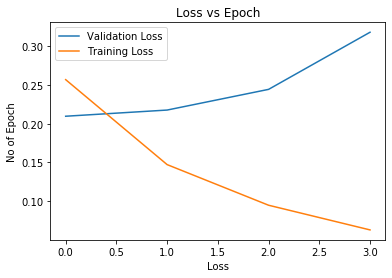

In [200]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.xlabel("Loss")
plt.ylabel("No of Epoch")
plt.title("Loss vs Epoch")
plt.legend(["Validation Loss","Training Loss"])

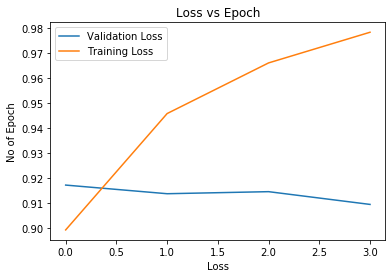

In [203]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.xlabel("Loss")
plt.ylabel("No of Epoch")
plt.title("Loss vs Epoch")
plt.legend(["Validation Loss","Training Loss"])

# Using Simple LSTM

In [206]:
# create the model
embedding_vecor_length = 32
top_words = 39384
model1 = Sequential()
model1.add(Embedding(top_words, embedding_vecor_length, input_length=len(x_train[0])))
model1.add(LSTM(100,return_sequences = True))
model1.add(Dropout(0.5))
model1.add(LSTM(64))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 600, 32)           1260288   
_________________________________________________________________
lstm_17 (LSTM)               (None, 600, 100)          53200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 600, 100)          0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 1,355,793
Trainable params: 1,355,793
Non-trainable params: 0
_________________________________________________________________
None


In [207]:
history1 = model1.fit(x_train, y_train, nb_epoch=8, batch_size=64,validation_data=(x_test,y_test))

Train on 40000 samples, validate on 6071 samples
Epoch 1/8


11264/40000 [=======>......................] - ETA: 55:51 - loss: 0.6924 - accuracy: 0.640 - ETA: 48:26 - loss: 0.6876 - accuracy: 0.765 - ETA: 45:04 - loss: 0.6835 - accuracy: 0.796 - ETA: 42:38 - loss: 0.6764 - accuracy: 0.828 - ETA: 41:30 - loss: 0.6713 - accuracy: 0.825 - ETA: 40:41 - loss: 0.6640 - accuracy: 0.825 - ETA: 40:00 - loss: 0.6523 - accuracy: 0.830 - ETA: 39:33 - loss: 0.6426 - accuracy: 0.824 - ETA: 39:12 - loss: 0.6207 - accuracy: 0.831 - ETA: 38:50 - loss: 0.6092 - accuracy: 0.829 - ETA: 38:30 - loss: 0.6040 - accuracy: 0.826 - ETA: 38:19 - loss: 0.5784 - accuracy: 0.833 - ETA: 38:02 - loss: 0.5697 - accuracy: 0.832 - ETA: 37:49 - loss: 0.5539 - accuracy: 0.837 - ETA: 37:29 - loss: 0.5411 - accuracy: 0.839 - ETA: 37:10 - loss: 0.5494 - accuracy: 0.831 - ETA: 36:51 - loss: 0.5481 - accuracy: 0.828 - ETA: 36:40 - loss: 0.5369 - accuracy: 0.832 - ETA: 36:24 - loss: 0.5319 - accuracy: 0.833 - ETA: 36:11 - loss: 0.5276 - accuracy: 0.833 - ETA: 36:00 - loss: 0.5191 - accur

22656/40000 [===============>..............] - ETA: 26:23 - loss: 0.3602 - accuracy: 0.862 - ETA: 26:19 - loss: 0.3592 - accuracy: 0.863 - ETA: 26:15 - loss: 0.3593 - accuracy: 0.863 - ETA: 26:11 - loss: 0.3585 - accuracy: 0.863 - ETA: 26:07 - loss: 0.3577 - accuracy: 0.863 - ETA: 26:03 - loss: 0.3577 - accuracy: 0.863 - ETA: 25:59 - loss: 0.3573 - accuracy: 0.863 - ETA: 25:55 - loss: 0.3568 - accuracy: 0.864 - ETA: 25:51 - loss: 0.3564 - accuracy: 0.864 - ETA: 25:48 - loss: 0.3554 - accuracy: 0.864 - ETA: 25:44 - loss: 0.3559 - accuracy: 0.864 - ETA: 25:40 - loss: 0.3552 - accuracy: 0.864 - ETA: 25:36 - loss: 0.3546 - accuracy: 0.864 - ETA: 25:33 - loss: 0.3536 - accuracy: 0.865 - ETA: 25:29 - loss: 0.3534 - accuracy: 0.865 - ETA: 25:25 - loss: 0.3528 - accuracy: 0.865 - ETA: 25:21 - loss: 0.3518 - accuracy: 0.865 - ETA: 25:18 - loss: 0.3512 - accuracy: 0.865 - ETA: 25:15 - loss: 0.3511 - accuracy: 0.865 - ETA: 25:12 - loss: 0.3505 - accuracy: 0.865 - ETA: 25:09 - loss: 0.3499 - accur

34240/40000 [========================>.....] - ETA: 15:34 - loss: 0.2989 - accuracy: 0.883 - ETA: 15:30 - loss: 0.2993 - accuracy: 0.883 - ETA: 15:26 - loss: 0.2989 - accuracy: 0.883 - ETA: 15:23 - loss: 0.2987 - accuracy: 0.883 - ETA: 15:19 - loss: 0.2986 - accuracy: 0.883 - ETA: 15:16 - loss: 0.2986 - accuracy: 0.883 - ETA: 15:12 - loss: 0.2984 - accuracy: 0.883 - ETA: 15:08 - loss: 0.2982 - accuracy: 0.883 - ETA: 15:05 - loss: 0.2983 - accuracy: 0.883 - ETA: 15:01 - loss: 0.2979 - accuracy: 0.883 - ETA: 14:58 - loss: 0.2977 - accuracy: 0.883 - ETA: 14:54 - loss: 0.2973 - accuracy: 0.883 - ETA: 14:50 - loss: 0.2971 - accuracy: 0.883 - ETA: 14:47 - loss: 0.2967 - accuracy: 0.883 - ETA: 14:43 - loss: 0.2963 - accuracy: 0.883 - ETA: 14:40 - loss: 0.2963 - accuracy: 0.884 - ETA: 14:36 - loss: 0.2961 - accuracy: 0.884 - ETA: 14:33 - loss: 0.2961 - accuracy: 0.884 - ETA: 14:29 - loss: 0.2957 - accuracy: 0.884 - ETA: 14:26 - loss: 0.2958 - accuracy: 0.884 - ETA: 14:22 - loss: 0.2959 - accur

40000/40000 [==============================] - ETA: 5:07 - loss: 0.2746 - accuracy: 0.89 - ETA: 5:03 - loss: 0.2745 - accuracy: 0.89 - ETA: 5:00 - loss: 0.2744 - accuracy: 0.89 - ETA: 4:56 - loss: 0.2741 - accuracy: 0.89 - ETA: 4:53 - loss: 0.2741 - accuracy: 0.89 - ETA: 4:49 - loss: 0.2740 - accuracy: 0.89 - ETA: 4:46 - loss: 0.2739 - accuracy: 0.89 - ETA: 4:42 - loss: 0.2739 - accuracy: 0.89 - ETA: 4:39 - loss: 0.2739 - accuracy: 0.89 - ETA: 4:35 - loss: 0.2738 - accuracy: 0.89 - ETA: 4:32 - loss: 0.2738 - accuracy: 0.89 - ETA: 4:29 - loss: 0.2734 - accuracy: 0.89 - ETA: 4:25 - loss: 0.2733 - accuracy: 0.89 - ETA: 4:22 - loss: 0.2737 - accuracy: 0.89 - ETA: 4:18 - loss: 0.2734 - accuracy: 0.89 - ETA: 4:15 - loss: 0.2733 - accuracy: 0.89 - ETA: 4:11 - loss: 0.2729 - accuracy: 0.89 - ETA: 4:08 - loss: 0.2729 - accuracy: 0.89 - ETA: 4:04 - loss: 0.2730 - accuracy: 0.89 - ETA: 4:01 - loss: 0.2728 - accuracy: 0.89 - ETA: 3:58 - loss: 0.2728 - accuracy: 0.89 - ETA: 3:54 - loss: 0.2727 - ac

11392/40000 [=======>......................] - ETA: 38:59 - loss: 0.1590 - accuracy: 0.906 - ETA: 37:25 - loss: 0.1599 - accuracy: 0.914 - ETA: 36:41 - loss: 0.1500 - accuracy: 0.921 - ETA: 36:08 - loss: 0.1585 - accuracy: 0.921 - ETA: 35:25 - loss: 0.1566 - accuracy: 0.928 - ETA: 35:00 - loss: 0.1537 - accuracy: 0.929 - ETA: 35:01 - loss: 0.1471 - accuracy: 0.933 - ETA: 35:57 - loss: 0.1428 - accuracy: 0.937 - ETA: 35:54 - loss: 0.1444 - accuracy: 0.939 - ETA: 35:41 - loss: 0.1425 - accuracy: 0.940 - ETA: 35:31 - loss: 0.1461 - accuracy: 0.938 - ETA: 36:03 - loss: 0.1408 - accuracy: 0.941 - ETA: 36:25 - loss: 0.1433 - accuracy: 0.942 - ETA: 36:23 - loss: 0.1423 - accuracy: 0.943 - ETA: 36:24 - loss: 0.1438 - accuracy: 0.943 - ETA: 36:14 - loss: 0.1405 - accuracy: 0.944 - ETA: 36:02 - loss: 0.1397 - accuracy: 0.942 - ETA: 35:54 - loss: 0.1417 - accuracy: 0.941 - ETA: 35:49 - loss: 0.1401 - accuracy: 0.944 - ETA: 35:40 - loss: 0.1410 - accuracy: 0.943 - ETA: 35:33 - loss: 0.1459 - accur

22784/40000 [================>.............] - ETA: 26:20 - loss: 0.1486 - accuracy: 0.946 - ETA: 26:16 - loss: 0.1482 - accuracy: 0.946 - ETA: 26:11 - loss: 0.1481 - accuracy: 0.947 - ETA: 26:08 - loss: 0.1479 - accuracy: 0.947 - ETA: 26:04 - loss: 0.1486 - accuracy: 0.946 - ETA: 26:00 - loss: 0.1494 - accuracy: 0.946 - ETA: 25:57 - loss: 0.1491 - accuracy: 0.946 - ETA: 25:54 - loss: 0.1487 - accuracy: 0.947 - ETA: 25:52 - loss: 0.1488 - accuracy: 0.947 - ETA: 25:49 - loss: 0.1485 - accuracy: 0.947 - ETA: 25:45 - loss: 0.1485 - accuracy: 0.947 - ETA: 25:41 - loss: 0.1481 - accuracy: 0.947 - ETA: 25:37 - loss: 0.1478 - accuracy: 0.947 - ETA: 25:33 - loss: 0.1474 - accuracy: 0.947 - ETA: 25:29 - loss: 0.1471 - accuracy: 0.947 - ETA: 25:24 - loss: 0.1470 - accuracy: 0.947 - ETA: 25:20 - loss: 0.1465 - accuracy: 0.947 - ETA: 25:16 - loss: 0.1463 - accuracy: 0.947 - ETA: 25:12 - loss: 0.1477 - accuracy: 0.947 - ETA: 25:08 - loss: 0.1477 - accuracy: 0.947 - ETA: 25:04 - loss: 0.1480 - accur

34368/40000 [========================>.....] - ETA: 15:31 - loss: 0.1510 - accuracy: 0.945 - ETA: 15:28 - loss: 0.1508 - accuracy: 0.945 - ETA: 15:24 - loss: 0.1508 - accuracy: 0.945 - ETA: 15:21 - loss: 0.1510 - accuracy: 0.945 - ETA: 15:18 - loss: 0.1508 - accuracy: 0.945 - ETA: 15:15 - loss: 0.1507 - accuracy: 0.945 - ETA: 15:11 - loss: 0.1506 - accuracy: 0.945 - ETA: 15:07 - loss: 0.1506 - accuracy: 0.945 - ETA: 15:04 - loss: 0.1504 - accuracy: 0.945 - ETA: 15:00 - loss: 0.1509 - accuracy: 0.945 - ETA: 14:57 - loss: 0.1511 - accuracy: 0.945 - ETA: 14:53 - loss: 0.1511 - accuracy: 0.945 - ETA: 14:50 - loss: 0.1513 - accuracy: 0.944 - ETA: 14:46 - loss: 0.1515 - accuracy: 0.944 - ETA: 14:42 - loss: 0.1516 - accuracy: 0.944 - ETA: 14:39 - loss: 0.1517 - accuracy: 0.944 - ETA: 14:35 - loss: 0.1520 - accuracy: 0.944 - ETA: 14:31 - loss: 0.1518 - accuracy: 0.944 - ETA: 14:28 - loss: 0.1518 - accuracy: 0.944 - ETA: 14:24 - loss: 0.1523 - accuracy: 0.944 - ETA: 14:21 - loss: 0.1523 - accur

40000/40000 [==============================] - ETA: 4:59 - loss: 0.1534 - accuracy: 0.94 - ETA: 4:56 - loss: 0.1531 - accuracy: 0.94 - ETA: 4:52 - loss: 0.1533 - accuracy: 0.94 - ETA: 4:49 - loss: 0.1534 - accuracy: 0.94 - ETA: 4:46 - loss: 0.1533 - accuracy: 0.94 - ETA: 4:42 - loss: 0.1532 - accuracy: 0.94 - ETA: 4:39 - loss: 0.1531 - accuracy: 0.94 - ETA: 4:35 - loss: 0.1529 - accuracy: 0.94 - ETA: 4:32 - loss: 0.1532 - accuracy: 0.94 - ETA: 4:29 - loss: 0.1532 - accuracy: 0.94 - ETA: 4:25 - loss: 0.1531 - accuracy: 0.94 - ETA: 4:22 - loss: 0.1532 - accuracy: 0.94 - ETA: 4:18 - loss: 0.1537 - accuracy: 0.94 - ETA: 4:15 - loss: 0.1538 - accuracy: 0.94 - ETA: 4:12 - loss: 0.1536 - accuracy: 0.94 - ETA: 4:08 - loss: 0.1535 - accuracy: 0.94 - ETA: 4:05 - loss: 0.1535 - accuracy: 0.94 - ETA: 4:01 - loss: 0.1540 - accuracy: 0.94 - ETA: 3:58 - loss: 0.1542 - accuracy: 0.94 - ETA: 3:54 - loss: 0.1544 - accuracy: 0.94 - ETA: 3:51 - loss: 0.1545 - accuracy: 0.94 - ETA: 3:48 - loss: 0.1545 - ac

11392/40000 [=======>......................] - ETA: 34:48 - loss: 0.0601 - accuracy: 0.984 - ETA: 34:19 - loss: 0.0875 - accuracy: 0.976 - ETA: 34:07 - loss: 0.0813 - accuracy: 0.979 - ETA: 33:49 - loss: 0.0815 - accuracy: 0.976 - ETA: 33:46 - loss: 0.0972 - accuracy: 0.968 - ETA: 33:46 - loss: 0.0872 - accuracy: 0.974 - ETA: 33:48 - loss: 0.0871 - accuracy: 0.975 - ETA: 33:40 - loss: 0.0877 - accuracy: 0.974 - ETA: 33:37 - loss: 0.0850 - accuracy: 0.977 - ETA: 33:36 - loss: 0.0806 - accuracy: 0.979 - ETA: 33:35 - loss: 0.0845 - accuracy: 0.978 - ETA: 33:28 - loss: 0.0909 - accuracy: 0.975 - ETA: 33:25 - loss: 0.0903 - accuracy: 0.974 - ETA: 33:24 - loss: 0.0902 - accuracy: 0.973 - ETA: 33:22 - loss: 0.0929 - accuracy: 0.971 - ETA: 33:19 - loss: 0.0904 - accuracy: 0.972 - ETA: 33:15 - loss: 0.0954 - accuracy: 0.971 - ETA: 33:14 - loss: 0.0923 - accuracy: 0.972 - ETA: 33:11 - loss: 0.0933 - accuracy: 0.972 - ETA: 33:06 - loss: 0.0961 - accuracy: 0.970 - ETA: 33:02 - loss: 0.1005 - accur

22784/40000 [================>.............] - ETA: 24:23 - loss: 0.1059 - accuracy: 0.963 - ETA: 24:20 - loss: 0.1057 - accuracy: 0.963 - ETA: 24:17 - loss: 0.1060 - accuracy: 0.963 - ETA: 24:14 - loss: 0.1062 - accuracy: 0.963 - ETA: 24:11 - loss: 0.1062 - accuracy: 0.963 - ETA: 24:08 - loss: 0.1067 - accuracy: 0.962 - ETA: 24:05 - loss: 0.1068 - accuracy: 0.962 - ETA: 24:02 - loss: 0.1069 - accuracy: 0.962 - ETA: 23:58 - loss: 0.1068 - accuracy: 0.962 - ETA: 23:55 - loss: 0.1067 - accuracy: 0.962 - ETA: 23:52 - loss: 0.1070 - accuracy: 0.962 - ETA: 23:49 - loss: 0.1070 - accuracy: 0.962 - ETA: 23:45 - loss: 0.1070 - accuracy: 0.962 - ETA: 23:42 - loss: 0.1077 - accuracy: 0.962 - ETA: 23:39 - loss: 0.1076 - accuracy: 0.962 - ETA: 23:35 - loss: 0.1074 - accuracy: 0.962 - ETA: 23:32 - loss: 0.1078 - accuracy: 0.962 - ETA: 23:29 - loss: 0.1075 - accuracy: 0.962 - ETA: 23:26 - loss: 0.1077 - accuracy: 0.962 - ETA: 23:22 - loss: 0.1076 - accuracy: 0.962 - ETA: 23:19 - loss: 0.1075 - accur

34432/40000 [========================>.....] - ETA: 14:43 - loss: 0.1070 - accuracy: 0.962 - ETA: 14:39 - loss: 0.1069 - accuracy: 0.962 - ETA: 14:36 - loss: 0.1067 - accuracy: 0.962 - ETA: 14:33 - loss: 0.1067 - accuracy: 0.962 - ETA: 14:29 - loss: 0.1069 - accuracy: 0.962 - ETA: 14:26 - loss: 0.1067 - accuracy: 0.962 - ETA: 14:23 - loss: 0.1069 - accuracy: 0.962 - ETA: 14:19 - loss: 0.1067 - accuracy: 0.962 - ETA: 14:16 - loss: 0.1070 - accuracy: 0.962 - ETA: 14:13 - loss: 0.1069 - accuracy: 0.962 - ETA: 14:10 - loss: 0.1071 - accuracy: 0.962 - ETA: 14:07 - loss: 0.1072 - accuracy: 0.962 - ETA: 14:04 - loss: 0.1073 - accuracy: 0.962 - ETA: 14:00 - loss: 0.1074 - accuracy: 0.962 - ETA: 13:57 - loss: 0.1073 - accuracy: 0.962 - ETA: 13:54 - loss: 0.1074 - accuracy: 0.962 - ETA: 13:50 - loss: 0.1074 - accuracy: 0.962 - ETA: 13:47 - loss: 0.1073 - accuracy: 0.962 - ETA: 13:44 - loss: 0.1077 - accuracy: 0.962 - ETA: 13:40 - loss: 0.1078 - accuracy: 0.962 - ETA: 13:37 - loss: 0.1078 - accur

40000/40000 [==============================] - ETA: 4:43 - loss: 0.1104 - accuracy: 0.96 - ETA: 4:40 - loss: 0.1106 - accuracy: 0.95 - ETA: 4:37 - loss: 0.1106 - accuracy: 0.95 - ETA: 4:33 - loss: 0.1109 - accuracy: 0.95 - ETA: 4:30 - loss: 0.1110 - accuracy: 0.95 - ETA: 4:27 - loss: 0.1111 - accuracy: 0.95 - ETA: 4:23 - loss: 0.1111 - accuracy: 0.95 - ETA: 4:20 - loss: 0.1110 - accuracy: 0.95 - ETA: 4:17 - loss: 0.1110 - accuracy: 0.95 - ETA: 4:14 - loss: 0.1108 - accuracy: 0.95 - ETA: 4:10 - loss: 0.1111 - accuracy: 0.95 - ETA: 4:07 - loss: 0.1110 - accuracy: 0.95 - ETA: 4:04 - loss: 0.1112 - accuracy: 0.95 - ETA: 4:00 - loss: 0.1114 - accuracy: 0.95 - ETA: 3:57 - loss: 0.1114 - accuracy: 0.95 - ETA: 3:54 - loss: 0.1113 - accuracy: 0.95 - ETA: 3:51 - loss: 0.1113 - accuracy: 0.95 - ETA: 3:47 - loss: 0.1114 - accuracy: 0.95 - ETA: 3:44 - loss: 0.1114 - accuracy: 0.95 - ETA: 3:41 - loss: 0.1116 - accuracy: 0.95 - ETA: 3:37 - loss: 0.1115 - accuracy: 0.95 - ETA: 3:34 - loss: 0.1115 - ac

11392/40000 [=======>......................] - ETA: 33:55 - loss: 0.0529 - accuracy: 1.000 - ETA: 33:40 - loss: 0.0411 - accuracy: 1.000 - ETA: 33:24 - loss: 0.0499 - accuracy: 0.989 - ETA: 33:18 - loss: 0.0463 - accuracy: 0.988 - ETA: 33:04 - loss: 0.0480 - accuracy: 0.987 - ETA: 32:56 - loss: 0.0456 - accuracy: 0.989 - ETA: 32:47 - loss: 0.0587 - accuracy: 0.984 - ETA: 33:01 - loss: 0.0693 - accuracy: 0.984 - ETA: 33:16 - loss: 0.0682 - accuracy: 0.982 - ETA: 33:17 - loss: 0.0725 - accuracy: 0.981 - ETA: 33:32 - loss: 0.0688 - accuracy: 0.983 - ETA: 33:34 - loss: 0.0651 - accuracy: 0.984 - ETA: 33:30 - loss: 0.0626 - accuracy: 0.984 - ETA: 33:22 - loss: 0.0634 - accuracy: 0.984 - ETA: 33:17 - loss: 0.0603 - accuracy: 0.985 - ETA: 33:14 - loss: 0.0595 - accuracy: 0.985 - ETA: 33:06 - loss: 0.0583 - accuracy: 0.985 - ETA: 33:00 - loss: 0.0620 - accuracy: 0.983 - ETA: 32:57 - loss: 0.0624 - accuracy: 0.981 - ETA: 32:54 - loss: 0.0644 - accuracy: 0.979 - ETA: 32:50 - loss: 0.0641 - accur

22784/40000 [================>.............] - ETA: 24:34 - loss: 0.0752 - accuracy: 0.975 - ETA: 24:30 - loss: 0.0753 - accuracy: 0.975 - ETA: 24:27 - loss: 0.0750 - accuracy: 0.975 - ETA: 24:24 - loss: 0.0747 - accuracy: 0.975 - ETA: 24:20 - loss: 0.0751 - accuracy: 0.975 - ETA: 24:16 - loss: 0.0749 - accuracy: 0.975 - ETA: 24:13 - loss: 0.0748 - accuracy: 0.975 - ETA: 24:10 - loss: 0.0753 - accuracy: 0.975 - ETA: 24:06 - loss: 0.0751 - accuracy: 0.975 - ETA: 24:03 - loss: 0.0751 - accuracy: 0.975 - ETA: 23:59 - loss: 0.0752 - accuracy: 0.975 - ETA: 23:56 - loss: 0.0753 - accuracy: 0.975 - ETA: 23:52 - loss: 0.0752 - accuracy: 0.975 - ETA: 23:49 - loss: 0.0752 - accuracy: 0.975 - ETA: 23:45 - loss: 0.0753 - accuracy: 0.975 - ETA: 23:42 - loss: 0.0754 - accuracy: 0.975 - ETA: 23:38 - loss: 0.0754 - accuracy: 0.975 - ETA: 23:35 - loss: 0.0755 - accuracy: 0.975 - ETA: 23:32 - loss: 0.0752 - accuracy: 0.975 - ETA: 23:29 - loss: 0.0752 - accuracy: 0.975 - ETA: 23:25 - loss: 0.0759 - accur

34432/40000 [========================>.....] - ETA: 14:52 - loss: 0.0788 - accuracy: 0.973 - ETA: 14:49 - loss: 0.0789 - accuracy: 0.973 - ETA: 14:46 - loss: 0.0792 - accuracy: 0.973 - ETA: 14:43 - loss: 0.0795 - accuracy: 0.973 - ETA: 14:39 - loss: 0.0796 - accuracy: 0.973 - ETA: 14:36 - loss: 0.0796 - accuracy: 0.973 - ETA: 14:33 - loss: 0.0797 - accuracy: 0.973 - ETA: 14:29 - loss: 0.0798 - accuracy: 0.973 - ETA: 14:26 - loss: 0.0798 - accuracy: 0.973 - ETA: 14:23 - loss: 0.0800 - accuracy: 0.973 - ETA: 14:19 - loss: 0.0800 - accuracy: 0.973 - ETA: 14:16 - loss: 0.0804 - accuracy: 0.973 - ETA: 14:12 - loss: 0.0806 - accuracy: 0.973 - ETA: 14:09 - loss: 0.0807 - accuracy: 0.973 - ETA: 14:06 - loss: 0.0806 - accuracy: 0.973 - ETA: 14:02 - loss: 0.0807 - accuracy: 0.972 - ETA: 13:59 - loss: 0.0807 - accuracy: 0.972 - ETA: 13:55 - loss: 0.0808 - accuracy: 0.972 - ETA: 13:52 - loss: 0.0809 - accuracy: 0.972 - ETA: 13:49 - loss: 0.0808 - accuracy: 0.972 - ETA: 13:45 - loss: 0.0807 - accur

40000/40000 [==============================] - ETA: 4:44 - loss: 0.0844 - accuracy: 0.97 - ETA: 4:41 - loss: 0.0845 - accuracy: 0.97 - ETA: 4:38 - loss: 0.0845 - accuracy: 0.97 - ETA: 4:34 - loss: 0.0844 - accuracy: 0.97 - ETA: 4:31 - loss: 0.0845 - accuracy: 0.97 - ETA: 4:28 - loss: 0.0844 - accuracy: 0.97 - ETA: 4:24 - loss: 0.0844 - accuracy: 0.97 - ETA: 4:21 - loss: 0.0843 - accuracy: 0.97 - ETA: 4:18 - loss: 0.0843 - accuracy: 0.97 - ETA: 4:14 - loss: 0.0842 - accuracy: 0.97 - ETA: 4:11 - loss: 0.0841 - accuracy: 0.97 - ETA: 4:08 - loss: 0.0841 - accuracy: 0.97 - ETA: 4:04 - loss: 0.0840 - accuracy: 0.97 - ETA: 4:01 - loss: 0.0839 - accuracy: 0.97 - ETA: 3:58 - loss: 0.0840 - accuracy: 0.97 - ETA: 3:54 - loss: 0.0839 - accuracy: 0.97 - ETA: 3:51 - loss: 0.0840 - accuracy: 0.97 - ETA: 3:48 - loss: 0.0840 - accuracy: 0.97 - ETA: 3:44 - loss: 0.0841 - accuracy: 0.97 - ETA: 3:41 - loss: 0.0840 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0841 - accuracy: 0.97 - ETA: 3:34 - loss: 0.0840 - ac

11392/40000 [=======>......................] - ETA: 33:01 - loss: 0.0511 - accuracy: 0.984 - ETA: 34:32 - loss: 0.0325 - accuracy: 0.992 - ETA: 35:05 - loss: 0.0335 - accuracy: 0.994 - ETA: 35:36 - loss: 0.0339 - accuracy: 0.996 - ETA: 36:14 - loss: 0.0446 - accuracy: 0.993 - ETA: 36:35 - loss: 0.0482 - accuracy: 0.992 - ETA: 36:41 - loss: 0.0507 - accuracy: 0.991 - ETA: 36:55 - loss: 0.0493 - accuracy: 0.990 - ETA: 36:51 - loss: 0.0480 - accuracy: 0.989 - ETA: 36:57 - loss: 0.0483 - accuracy: 0.989 - ETA: 37:19 - loss: 0.0463 - accuracy: 0.990 - ETA: 37:25 - loss: 0.0481 - accuracy: 0.989 - ETA: 37:10 - loss: 0.0460 - accuracy: 0.990 - ETA: 36:58 - loss: 0.0479 - accuracy: 0.988 - ETA: 36:47 - loss: 0.0457 - accuracy: 0.989 - ETA: 36:31 - loss: 0.0438 - accuracy: 0.990 - ETA: 36:14 - loss: 0.0448 - accuracy: 0.988 - ETA: 35:59 - loss: 0.0448 - accuracy: 0.987 - ETA: 35:44 - loss: 0.0470 - accuracy: 0.987 - ETA: 35:37 - loss: 0.0450 - accuracy: 0.988 - ETA: 35:33 - loss: 0.0437 - accur

22784/40000 [================>.............] - ETA: 24:53 - loss: 0.0554 - accuracy: 0.983 - ETA: 24:50 - loss: 0.0554 - accuracy: 0.983 - ETA: 24:46 - loss: 0.0551 - accuracy: 0.983 - ETA: 24:42 - loss: 0.0554 - accuracy: 0.983 - ETA: 24:39 - loss: 0.0553 - accuracy: 0.983 - ETA: 24:35 - loss: 0.0551 - accuracy: 0.983 - ETA: 24:31 - loss: 0.0554 - accuracy: 0.983 - ETA: 24:28 - loss: 0.0552 - accuracy: 0.983 - ETA: 24:24 - loss: 0.0550 - accuracy: 0.983 - ETA: 24:20 - loss: 0.0549 - accuracy: 0.983 - ETA: 24:17 - loss: 0.0547 - accuracy: 0.983 - ETA: 24:13 - loss: 0.0547 - accuracy: 0.983 - ETA: 24:10 - loss: 0.0545 - accuracy: 0.984 - ETA: 24:06 - loss: 0.0545 - accuracy: 0.984 - ETA: 24:02 - loss: 0.0545 - accuracy: 0.984 - ETA: 23:59 - loss: 0.0544 - accuracy: 0.984 - ETA: 23:55 - loss: 0.0547 - accuracy: 0.983 - ETA: 23:52 - loss: 0.0547 - accuracy: 0.983 - ETA: 23:48 - loss: 0.0548 - accuracy: 0.983 - ETA: 23:44 - loss: 0.0549 - accuracy: 0.983 - ETA: 23:41 - loss: 0.0547 - accur

34432/40000 [========================>.....] - ETA: 14:55 - loss: 0.0568 - accuracy: 0.982 - ETA: 14:51 - loss: 0.0567 - accuracy: 0.982 - ETA: 14:48 - loss: 0.0566 - accuracy: 0.982 - ETA: 14:45 - loss: 0.0565 - accuracy: 0.982 - ETA: 14:41 - loss: 0.0564 - accuracy: 0.982 - ETA: 14:38 - loss: 0.0563 - accuracy: 0.982 - ETA: 14:34 - loss: 0.0565 - accuracy: 0.982 - ETA: 14:31 - loss: 0.0566 - accuracy: 0.982 - ETA: 14:28 - loss: 0.0565 - accuracy: 0.982 - ETA: 14:24 - loss: 0.0566 - accuracy: 0.982 - ETA: 14:21 - loss: 0.0566 - accuracy: 0.982 - ETA: 14:17 - loss: 0.0566 - accuracy: 0.982 - ETA: 14:14 - loss: 0.0565 - accuracy: 0.982 - ETA: 14:11 - loss: 0.0565 - accuracy: 0.982 - ETA: 14:07 - loss: 0.0565 - accuracy: 0.982 - ETA: 14:04 - loss: 0.0565 - accuracy: 0.982 - ETA: 14:01 - loss: 0.0565 - accuracy: 0.982 - ETA: 13:58 - loss: 0.0565 - accuracy: 0.982 - ETA: 13:54 - loss: 0.0565 - accuracy: 0.982 - ETA: 13:51 - loss: 0.0566 - accuracy: 0.982 - ETA: 13:48 - loss: 0.0565 - accur

40000/40000 [==============================] - ETA: 4:46 - loss: 0.0589 - accuracy: 0.98 - ETA: 4:43 - loss: 0.0593 - accuracy: 0.98 - ETA: 4:40 - loss: 0.0592 - accuracy: 0.98 - ETA: 4:36 - loss: 0.0592 - accuracy: 0.98 - ETA: 4:33 - loss: 0.0594 - accuracy: 0.98 - ETA: 4:30 - loss: 0.0595 - accuracy: 0.98 - ETA: 4:26 - loss: 0.0595 - accuracy: 0.98 - ETA: 4:23 - loss: 0.0594 - accuracy: 0.98 - ETA: 4:20 - loss: 0.0594 - accuracy: 0.98 - ETA: 4:17 - loss: 0.0594 - accuracy: 0.98 - ETA: 4:13 - loss: 0.0594 - accuracy: 0.98 - ETA: 4:10 - loss: 0.0595 - accuracy: 0.98 - ETA: 4:07 - loss: 0.0595 - accuracy: 0.98 - ETA: 4:04 - loss: 0.0594 - accuracy: 0.98 - ETA: 4:00 - loss: 0.0594 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0594 - accuracy: 0.98 - ETA: 3:54 - loss: 0.0596 - accuracy: 0.98 - ETA: 3:50 - loss: 0.0595 - accuracy: 0.98 - ETA: 3:47 - loss: 0.0597 - accuracy: 0.98 - ETA: 3:44 - loss: 0.0596 - accuracy: 0.98 - ETA: 3:40 - loss: 0.0595 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0595 - ac

11392/40000 [=======>......................] - ETA: 45:14 - loss: 0.0194 - accuracy: 1.000 - ETA: 42:56 - loss: 0.0161 - accuracy: 1.000 - ETA: 39:49 - loss: 0.0464 - accuracy: 0.989 - ETA: 38:11 - loss: 0.0381 - accuracy: 0.992 - ETA: 37:14 - loss: 0.0374 - accuracy: 0.993 - ETA: 36:35 - loss: 0.0353 - accuracy: 0.994 - ETA: 35:59 - loss: 0.0316 - accuracy: 0.995 - ETA: 35:32 - loss: 0.0293 - accuracy: 0.996 - ETA: 35:51 - loss: 0.0268 - accuracy: 0.996 - ETA: 35:57 - loss: 0.0265 - accuracy: 0.995 - ETA: 36:22 - loss: 0.0257 - accuracy: 0.995 - ETA: 36:47 - loss: 0.0239 - accuracy: 0.996 - ETA: 37:01 - loss: 0.0234 - accuracy: 0.996 - ETA: 36:52 - loss: 0.0243 - accuracy: 0.995 - ETA: 36:32 - loss: 0.0240 - accuracy: 0.995 - ETA: 36:41 - loss: 0.0232 - accuracy: 0.996 - ETA: 37:04 - loss: 0.0252 - accuracy: 0.995 - ETA: 37:06 - loss: 0.0240 - accuracy: 0.995 - ETA: 36:54 - loss: 0.0230 - accuracy: 0.995 - ETA: 37:02 - loss: 0.0292 - accuracy: 0.995 - ETA: 37:15 - loss: 0.0283 - accur

22784/40000 [================>.............] - ETA: 24:48 - loss: 0.0365 - accuracy: 0.988 - ETA: 24:45 - loss: 0.0369 - accuracy: 0.988 - ETA: 24:41 - loss: 0.0369 - accuracy: 0.988 - ETA: 24:37 - loss: 0.0369 - accuracy: 0.988 - ETA: 24:34 - loss: 0.0368 - accuracy: 0.988 - ETA: 24:30 - loss: 0.0366 - accuracy: 0.988 - ETA: 24:26 - loss: 0.0373 - accuracy: 0.988 - ETA: 24:23 - loss: 0.0372 - accuracy: 0.988 - ETA: 24:19 - loss: 0.0376 - accuracy: 0.988 - ETA: 24:15 - loss: 0.0376 - accuracy: 0.987 - ETA: 24:12 - loss: 0.0375 - accuracy: 0.988 - ETA: 24:08 - loss: 0.0374 - accuracy: 0.988 - ETA: 24:05 - loss: 0.0373 - accuracy: 0.988 - ETA: 24:01 - loss: 0.0377 - accuracy: 0.988 - ETA: 23:57 - loss: 0.0380 - accuracy: 0.987 - ETA: 23:54 - loss: 0.0383 - accuracy: 0.987 - ETA: 23:50 - loss: 0.0381 - accuracy: 0.987 - ETA: 23:47 - loss: 0.0382 - accuracy: 0.987 - ETA: 23:43 - loss: 0.0380 - accuracy: 0.987 - ETA: 23:39 - loss: 0.0379 - accuracy: 0.988 - ETA: 23:36 - loss: 0.0379 - accur

34432/40000 [========================>.....] - ETA: 14:44 - loss: 0.0393 - accuracy: 0.987 - ETA: 14:41 - loss: 0.0392 - accuracy: 0.987 - ETA: 14:37 - loss: 0.0392 - accuracy: 0.987 - ETA: 14:34 - loss: 0.0392 - accuracy: 0.987 - ETA: 14:31 - loss: 0.0392 - accuracy: 0.987 - ETA: 14:27 - loss: 0.0391 - accuracy: 0.987 - ETA: 14:24 - loss: 0.0390 - accuracy: 0.987 - ETA: 14:20 - loss: 0.0390 - accuracy: 0.987 - ETA: 14:17 - loss: 0.0390 - accuracy: 0.987 - ETA: 14:14 - loss: 0.0389 - accuracy: 0.988 - ETA: 14:10 - loss: 0.0388 - accuracy: 0.988 - ETA: 14:07 - loss: 0.0389 - accuracy: 0.987 - ETA: 14:03 - loss: 0.0389 - accuracy: 0.987 - ETA: 14:00 - loss: 0.0388 - accuracy: 0.988 - ETA: 13:57 - loss: 0.0387 - accuracy: 0.988 - ETA: 13:53 - loss: 0.0387 - accuracy: 0.988 - ETA: 13:50 - loss: 0.0387 - accuracy: 0.988 - ETA: 13:47 - loss: 0.0387 - accuracy: 0.988 - ETA: 13:43 - loss: 0.0386 - accuracy: 0.988 - ETA: 13:40 - loss: 0.0386 - accuracy: 0.988 - ETA: 13:36 - loss: 0.0386 - accur

40000/40000 [==============================] - ETA: 4:40 - loss: 0.0419 - accuracy: 0.98 - ETA: 4:37 - loss: 0.0419 - accuracy: 0.98 - ETA: 4:33 - loss: 0.0418 - accuracy: 0.98 - ETA: 4:30 - loss: 0.0419 - accuracy: 0.98 - ETA: 4:27 - loss: 0.0420 - accuracy: 0.98 - ETA: 4:24 - loss: 0.0420 - accuracy: 0.98 - ETA: 4:20 - loss: 0.0419 - accuracy: 0.98 - ETA: 4:17 - loss: 0.0420 - accuracy: 0.98 - ETA: 4:14 - loss: 0.0419 - accuracy: 0.98 - ETA: 4:10 - loss: 0.0419 - accuracy: 0.98 - ETA: 4:07 - loss: 0.0419 - accuracy: 0.98 - ETA: 4:04 - loss: 0.0418 - accuracy: 0.98 - ETA: 4:01 - loss: 0.0420 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0421 - accuracy: 0.98 - ETA: 3:54 - loss: 0.0421 - accuracy: 0.98 - ETA: 3:51 - loss: 0.0421 - accuracy: 0.98 - ETA: 3:48 - loss: 0.0420 - accuracy: 0.98 - ETA: 3:44 - loss: 0.0422 - accuracy: 0.98 - ETA: 3:41 - loss: 0.0423 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0423 - accuracy: 0.98 - ETA: 3:34 - loss: 0.0424 - accuracy: 0.98 - ETA: 3:31 - loss: 0.0423 - ac

11392/40000 [=======>......................] - ETA: 32:27 - loss: 0.0362 - accuracy: 0.968 - ETA: 32:46 - loss: 0.0290 - accuracy: 0.984 - ETA: 32:50 - loss: 0.0231 - accuracy: 0.989 - ETA: 32:51 - loss: 0.0244 - accuracy: 0.988 - ETA: 32:46 - loss: 0.0204 - accuracy: 0.990 - ETA: 32:36 - loss: 0.0212 - accuracy: 0.992 - ETA: 32:32 - loss: 0.0202 - accuracy: 0.993 - ETA: 32:34 - loss: 0.0188 - accuracy: 0.994 - ETA: 32:31 - loss: 0.0198 - accuracy: 0.994 - ETA: 32:26 - loss: 0.0185 - accuracy: 0.995 - ETA: 32:24 - loss: 0.0178 - accuracy: 0.995 - ETA: 32:22 - loss: 0.0174 - accuracy: 0.996 - ETA: 32:18 - loss: 0.0166 - accuracy: 0.996 - ETA: 32:14 - loss: 0.0240 - accuracy: 0.995 - ETA: 32:11 - loss: 0.0247 - accuracy: 0.994 - ETA: 32:09 - loss: 0.0234 - accuracy: 0.995 - ETA: 32:05 - loss: 0.0234 - accuracy: 0.995 - ETA: 32:00 - loss: 0.0233 - accuracy: 0.994 - ETA: 31:57 - loss: 0.0228 - accuracy: 0.995 - ETA: 31:54 - loss: 0.0219 - accuracy: 0.995 - ETA: 31:49 - loss: 0.0211 - accur

22784/40000 [================>.............] - ETA: 23:35 - loss: 0.0268 - accuracy: 0.992 - ETA: 23:32 - loss: 0.0267 - accuracy: 0.992 - ETA: 23:29 - loss: 0.0266 - accuracy: 0.992 - ETA: 23:26 - loss: 0.0266 - accuracy: 0.992 - ETA: 23:23 - loss: 0.0265 - accuracy: 0.992 - ETA: 23:19 - loss: 0.0264 - accuracy: 0.993 - ETA: 23:16 - loss: 0.0263 - accuracy: 0.993 - ETA: 23:13 - loss: 0.0262 - accuracy: 0.993 - ETA: 23:10 - loss: 0.0261 - accuracy: 0.993 - ETA: 23:07 - loss: 0.0264 - accuracy: 0.993 - ETA: 23:03 - loss: 0.0263 - accuracy: 0.993 - ETA: 23:00 - loss: 0.0263 - accuracy: 0.992 - ETA: 22:57 - loss: 0.0262 - accuracy: 0.993 - ETA: 22:54 - loss: 0.0262 - accuracy: 0.992 - ETA: 22:51 - loss: 0.0261 - accuracy: 0.993 - ETA: 22:48 - loss: 0.0260 - accuracy: 0.993 - ETA: 22:45 - loss: 0.0260 - accuracy: 0.992 - ETA: 22:41 - loss: 0.0266 - accuracy: 0.992 - ETA: 22:38 - loss: 0.0265 - accuracy: 0.992 - ETA: 22:35 - loss: 0.0263 - accuracy: 0.993 - ETA: 22:32 - loss: 0.0262 - accur

34432/40000 [========================>.....] - ETA: 14:11 - loss: 0.0296 - accuracy: 0.991 - ETA: 14:08 - loss: 0.0296 - accuracy: 0.991 - ETA: 14:05 - loss: 0.0297 - accuracy: 0.991 - ETA: 14:02 - loss: 0.0297 - accuracy: 0.991 - ETA: 13:59 - loss: 0.0296 - accuracy: 0.991 - ETA: 13:55 - loss: 0.0297 - accuracy: 0.991 - ETA: 13:52 - loss: 0.0296 - accuracy: 0.991 - ETA: 13:49 - loss: 0.0297 - accuracy: 0.991 - ETA: 13:46 - loss: 0.0297 - accuracy: 0.991 - ETA: 13:43 - loss: 0.0297 - accuracy: 0.991 - ETA: 13:40 - loss: 0.0297 - accuracy: 0.991 - ETA: 13:36 - loss: 0.0296 - accuracy: 0.991 - ETA: 13:33 - loss: 0.0296 - accuracy: 0.991 - ETA: 13:30 - loss: 0.0296 - accuracy: 0.991 - ETA: 13:27 - loss: 0.0297 - accuracy: 0.991 - ETA: 13:24 - loss: 0.0296 - accuracy: 0.991 - ETA: 13:21 - loss: 0.0296 - accuracy: 0.991 - ETA: 13:18 - loss: 0.0295 - accuracy: 0.991 - ETA: 13:15 - loss: 0.0295 - accuracy: 0.991 - ETA: 13:12 - loss: 0.0297 - accuracy: 0.991 - ETA: 13:09 - loss: 0.0297 - accur

40000/40000 [==============================] - ETA: 4:38 - loss: 0.0321 - accuracy: 0.98 - ETA: 4:35 - loss: 0.0321 - accuracy: 0.98 - ETA: 4:32 - loss: 0.0320 - accuracy: 0.98 - ETA: 4:29 - loss: 0.0320 - accuracy: 0.98 - ETA: 4:26 - loss: 0.0320 - accuracy: 0.98 - ETA: 4:22 - loss: 0.0320 - accuracy: 0.98 - ETA: 4:19 - loss: 0.0320 - accuracy: 0.98 - ETA: 4:16 - loss: 0.0320 - accuracy: 0.98 - ETA: 4:13 - loss: 0.0320 - accuracy: 0.98 - ETA: 4:10 - loss: 0.0319 - accuracy: 0.98 - ETA: 4:06 - loss: 0.0320 - accuracy: 0.98 - ETA: 4:03 - loss: 0.0319 - accuracy: 0.98 - ETA: 4:00 - loss: 0.0319 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0319 - accuracy: 0.98 - ETA: 3:53 - loss: 0.0318 - accuracy: 0.98 - ETA: 3:50 - loss: 0.0319 - accuracy: 0.98 - ETA: 3:47 - loss: 0.0320 - accuracy: 0.98 - ETA: 3:44 - loss: 0.0319 - accuracy: 0.98 - ETA: 3:40 - loss: 0.0319 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0320 - accuracy: 0.98 - ETA: 3:34 - loss: 0.0320 - accuracy: 0.98 - ETA: 3:31 - loss: 0.0320 - ac

11392/40000 [=======>......................] - ETA: 35:37 - loss: 0.0086 - accuracy: 1.000 - ETA: 35:20 - loss: 0.0256 - accuracy: 1.000 - ETA: 35:27 - loss: 0.0187 - accuracy: 1.000 - ETA: 35:36 - loss: 0.0195 - accuracy: 0.996 - ETA: 35:22 - loss: 0.0206 - accuracy: 0.993 - ETA: 35:13 - loss: 0.0192 - accuracy: 0.994 - ETA: 35:05 - loss: 0.0189 - accuracy: 0.995 - ETA: 35:04 - loss: 0.0216 - accuracy: 0.994 - ETA: 35:02 - loss: 0.0203 - accuracy: 0.994 - ETA: 34:55 - loss: 0.0202 - accuracy: 0.993 - ETA: 34:51 - loss: 0.0186 - accuracy: 0.994 - ETA: 34:47 - loss: 0.0186 - accuracy: 0.994 - ETA: 34:49 - loss: 0.0184 - accuracy: 0.994 - ETA: 34:44 - loss: 0.0178 - accuracy: 0.994 - ETA: 34:39 - loss: 0.0173 - accuracy: 0.994 - ETA: 34:34 - loss: 0.0236 - accuracy: 0.994 - ETA: 34:31 - loss: 0.0223 - accuracy: 0.994 - ETA: 34:29 - loss: 0.0220 - accuracy: 0.993 - ETA: 34:27 - loss: 0.0213 - accuracy: 0.994 - ETA: 34:22 - loss: 0.0204 - accuracy: 0.994 - ETA: 34:17 - loss: 0.0196 - accur

22784/40000 [================>.............] - ETA: 25:40 - loss: 0.0245 - accuracy: 0.993 - ETA: 25:36 - loss: 0.0243 - accuracy: 0.993 - ETA: 25:32 - loss: 0.0243 - accuracy: 0.993 - ETA: 25:29 - loss: 0.0244 - accuracy: 0.993 - ETA: 25:25 - loss: 0.0243 - accuracy: 0.993 - ETA: 25:21 - loss: 0.0242 - accuracy: 0.993 - ETA: 25:18 - loss: 0.0244 - accuracy: 0.993 - ETA: 25:14 - loss: 0.0243 - accuracy: 0.993 - ETA: 25:10 - loss: 0.0242 - accuracy: 0.993 - ETA: 25:07 - loss: 0.0243 - accuracy: 0.993 - ETA: 25:03 - loss: 0.0241 - accuracy: 0.993 - ETA: 25:00 - loss: 0.0241 - accuracy: 0.993 - ETA: 24:57 - loss: 0.0241 - accuracy: 0.993 - ETA: 24:53 - loss: 0.0240 - accuracy: 0.993 - ETA: 24:50 - loss: 0.0239 - accuracy: 0.993 - ETA: 24:47 - loss: 0.0238 - accuracy: 0.993 - ETA: 24:45 - loss: 0.0237 - accuracy: 0.993 - ETA: 24:41 - loss: 0.0236 - accuracy: 0.993 - ETA: 24:38 - loss: 0.0239 - accuracy: 0.993 - ETA: 24:34 - loss: 0.0239 - accuracy: 0.993 - ETA: 24:32 - loss: 0.0239 - accur

34432/40000 [========================>.....] - ETA: 15:11 - loss: 0.0243 - accuracy: 0.993 - ETA: 15:07 - loss: 0.0242 - accuracy: 0.993 - ETA: 15:03 - loss: 0.0242 - accuracy: 0.993 - ETA: 15:00 - loss: 0.0241 - accuracy: 0.993 - ETA: 14:56 - loss: 0.0241 - accuracy: 0.993 - ETA: 14:53 - loss: 0.0241 - accuracy: 0.993 - ETA: 14:49 - loss: 0.0241 - accuracy: 0.993 - ETA: 14:46 - loss: 0.0242 - accuracy: 0.993 - ETA: 14:42 - loss: 0.0242 - accuracy: 0.993 - ETA: 14:39 - loss: 0.0242 - accuracy: 0.993 - ETA: 14:35 - loss: 0.0241 - accuracy: 0.993 - ETA: 14:32 - loss: 0.0242 - accuracy: 0.993 - ETA: 14:28 - loss: 0.0241 - accuracy: 0.993 - ETA: 14:25 - loss: 0.0241 - accuracy: 0.993 - ETA: 14:21 - loss: 0.0241 - accuracy: 0.993 - ETA: 14:18 - loss: 0.0240 - accuracy: 0.993 - ETA: 14:14 - loss: 0.0240 - accuracy: 0.993 - ETA: 14:10 - loss: 0.0240 - accuracy: 0.993 - ETA: 14:07 - loss: 0.0240 - accuracy: 0.993 - ETA: 14:03 - loss: 0.0240 - accuracy: 0.993 - ETA: 14:00 - loss: 0.0240 - accur

40000/40000 [==============================] - ETA: 4:47 - loss: 0.0266 - accuracy: 0.99 - ETA: 4:44 - loss: 0.0266 - accuracy: 0.99 - ETA: 4:40 - loss: 0.0266 - accuracy: 0.99 - ETA: 4:37 - loss: 0.0266 - accuracy: 0.99 - ETA: 4:34 - loss: 0.0266 - accuracy: 0.99 - ETA: 4:30 - loss: 0.0265 - accuracy: 0.99 - ETA: 4:27 - loss: 0.0265 - accuracy: 0.99 - ETA: 4:24 - loss: 0.0265 - accuracy: 0.99 - ETA: 4:20 - loss: 0.0265 - accuracy: 0.99 - ETA: 4:17 - loss: 0.0264 - accuracy: 0.99 - ETA: 4:14 - loss: 0.0264 - accuracy: 0.99 - ETA: 4:10 - loss: 0.0264 - accuracy: 0.99 - ETA: 4:07 - loss: 0.0264 - accuracy: 0.99 - ETA: 4:04 - loss: 0.0264 - accuracy: 0.99 - ETA: 4:00 - loss: 0.0264 - accuracy: 0.99 - ETA: 3:57 - loss: 0.0263 - accuracy: 0.99 - ETA: 3:54 - loss: 0.0263 - accuracy: 0.99 - ETA: 3:50 - loss: 0.0263 - accuracy: 0.99 - ETA: 3:47 - loss: 0.0262 - accuracy: 0.99 - ETA: 3:44 - loss: 0.0263 - accuracy: 0.99 - ETA: 3:40 - loss: 0.0262 - accuracy: 0.99 - ETA: 3:37 - loss: 0.0262 - ac

In [211]:
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 90.94%


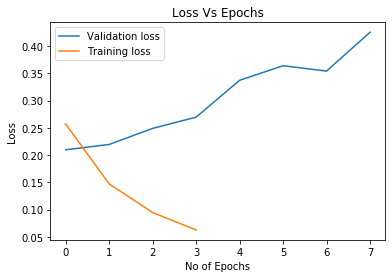

In [210]:
val_loss=history1.history['val_loss']
loss=history1.history['loss']
plt.plot(val_loss)
plt.plot(loss)
plt.legend(["Validation loss","Training loss"])
plt.xlabel("No of Epochs")
plt.ylabel("Loss")
plt.title("Loss Vs Epochs")
plt.show()

Steps taken :
1. Load the dataset.
2. Preprocess the dataset.
3. Create the vocabulary.
4. Create the dictionary.
5. Convert the given dataset into numerical representation.
6. Define the architecture of the LSTM model.
7. Complie the model.
8. Execute the model for 10 epochs.
9. Plot the graph between train and cross validation accuracy.
10. use different-different architecture.